In [1]:
import numpy as np
from scipy.stats import norm
import numpy as np
import astropy
from astropy.io import fits
from astropy import units as u
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import healpy as hp
import pandas as pd
import math
import scipy
import statistics as st
from scipy import stats
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image

%matplotlib inline

NSIDE=2048
Npix=12*NSIDE**2

pi=math.pi

import warnings
warnings.filterwarnings('ignore')

---

### Read in MMF3

In [16]:
amfFull = pd.read_csv('data/amfFull.tsv',sep='|')

c = SkyCoord(amfFull['RAJ2000'],amfFull['DEJ2000'],frame='icrs',unit='deg')

amfFull['GLAT'] = c.galactic.b.degree
amfFull['GLON'] = c.galactic.l.degree

amfFull['GLAT'] = np.around(amfFull['GLAT'].values,1)
amfFull['GLON'] = np.around(amfFull['GLON'].values,1)
print(amfFull.iloc[0,11]) # glat
print(amfFull.iloc[0,12]) # glon
amfFull

-40.9
136.7


ID              AMF9   RAJ2000  DEJ2000       z        Lk  \
0          4  J013539.1+204447   23.9128  20.7465  0.0601  176.9125   
1          5  J172231.8+320823  260.6324  32.1398  0.2252  222.1219   
2          6  J131131.1-012008  197.8796  -1.3356  0.2042  171.6872   
3          7  J164035.6+464130  250.1485  46.6917  0.2248  225.9874   
4          8  J230521.6+210216  346.3402  21.0378  0.1453  121.0124   
...      ...               ...       ...      ...     ...       ...   
46474  54273  J212414.7-053519  321.0614  -5.5885  0.4036    7.3319   
46475  54274  J104720.5-025526  161.7603  -2.9238  0.2064   11.9584   
46476  54275  J213855.7+153523  324.7319  15.5898  0.1964    8.6750   
46477  54276  J085114.6+015313  132.8109   1.8870  0.2697   12.2539   
46478  54277  J132144.5+565017  200.4356  56.8381  0.1359   16.1046   

       Lambda200   r200     rc      c   str-rh  GLAT   GLON  
0       219.3663  1.946  0.925  2.104  73.0001 -40.9  136.7  
1       200.7117  1.784  0.625  2.856  35.0001  31.8   55.6  
2       192.0829  1.773  0.227  7.792   9.0001  61.1  313.4  
3       182.3373  1.725  0.495  3.483  36.0001  41.4   72.6  
4       182.2769  1.775  0.440  4.034  72.0001 -35.4   92.2  
...          ...    ...    ...    ...      ...   ...    ...  
46474    20.0008  0.734  0.260  2.823  85.1216 -36.3   46.9  
46475    20.0006  0.790  0.090  8.781   9.1111  47.5  253.1  
46476    20.0005  0.793  0.180  4.404  73.0886 -26.7   69.5  
46477    20.0002  0.772  0.260  2.971  12.1012  27.3  225.8  
46478    20.0000  0.810  0.210  3.855  33.1023  59.8  114.7  

[46479 rows x 13 columns]

### Check against union mask

In [22]:
mask = hp.read_map('HFI_PCCS_SZ-selfunc-union-survey_2.02.fits')

# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[((maskedArray.glat > 17)|((maskedArray.glat<-10) & ((maskedArray.glon<210)))) | ((maskedArray.glat>0) & ((maskedArray.glon<240)&(maskedArray.glon>180)))].reset_index()

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


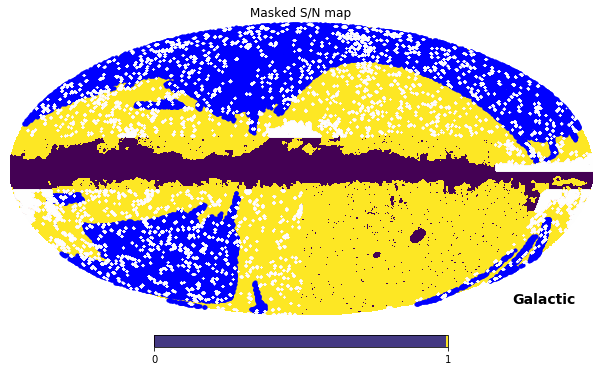

In [23]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='b',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)

In [24]:
# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[(maskedArray.glat > 15)|((maskedArray.glat<-15) & ((maskedArray.glon<210)))].reset_index()

In [ ]:
unionLons = []
unionLats = []

for i in range(amfFull.shape[0]):
    matchFlag=False
    for j in range(11): # Within 1 degree
        print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
        if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]+j/10, maskedArray.glat == amfFull.iloc[i][11]+j/10)].empty:
            print("MATCH")
            matchFlag=True
            unionLons.append(amfFull.iloc[i][12])
            unionLats.append(amfFull.iloc[i][11])
            break
    if not matchFlag:
        for j in range(11): # Within 1 degree
            print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
            if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]-j/10, maskedArray.glat == amfFull.iloc[i][11]-j/10)].empty:
                print("MATCH")
                matchFlag=True
                unionLons.append(amfFull.iloc[i][12])
                unionLats.append(amfFull.iloc[i][11])
                break
masked = pd.DataFrame({'glon': unionLons, 'glat': unionLats})

0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
MATCH
4 92.2 -35.4
MATCH
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5

32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
35 155.2 -14.6
MATCH
36 50.1 -27.3
36 50.1 -27.3
36 50.1 -27.3
36 50.1 -27.3
36 50.1 -27.3
36 50.1 -27

62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 9

92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 77.9 -26.6
95 7

120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 75.2
123 228.2 7

147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
150 166.7 42.1
150 166.7 42.1
150 166.7 42.1
150 166.7 42.1
150 166.7 42.1
15

174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.

200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
MATCH
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
MATCH
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
20

229 204.1 16.5
229 204.1 16.5
230 228.5 57.9
MATCH
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 

258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 5

286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
289 91.0 -39.5
MATCH
290 163.0 38

314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
317 134.6 -49.1
31

344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
345 160.6 38.7
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
346 82.5 -49.6
347 306.2 67.5
347 306.2 67.5
347 306.2 67.5
347 306.2 67.5
347 306.

372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
372 130.2 74.1
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
373 66.0 48.9
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
374 111.3 62.6
375 231.5 54.7
375 231.5 54.7
375 231.5 54.7
375 231.5 54.7
37

400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
400 175.2 -55.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
401 144.3 -70.0
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
402 273.7 63.3
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.8 40.0
403 225.

427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
427 210.6 82.2
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
428 84.7 42.3
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
429 101.9 -28.9
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 35.1
430 186.6 

454 139.6 -12.3
454 139.6 -12.3
455 103.4 -26.5
MATCH
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
456 68.4 -51.7
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
457 145.9 -12.5
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1 39.0
458 221.1

483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
483 227.6 54.9
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
484 230.4 71.5
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
485 96.7 -30.0
486 69.9 -

508 113.3 -29.7
508 113.3 -29.7
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
509 65.1 -44.1
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
510 60.1 64.5
511 91.2 -50.7
511 91.2 -50.7
MATCH
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3
512 17.9 68.3


536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
536 140.4 -41.6
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
537 114.2 58.9
MATCH
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
538 191.7 -33.1
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 66.1 -38.3
539 

566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
566 132.1 -46.7
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
567 275.2 64.2
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
568 152.4 81.3
569 81.2 -41.9
569 81.2 -41.9
569 81.2 -41.9
569 81.2 -41.9
569 81.2 -41.9
569 81.2 -41.9
569 81.2 -

594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
594 64.1 -53.7
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
595 174.4 -57.3
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
596 93.6 -31.9
597 151.6 69.3
597

620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
620 144.7 48.7
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
621 203.3 79.4
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
622 154.7 -62.7
623 96.6 -50.3
623 96.6 -50.3
623

649 117.8 -56.0
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
650 67.2 -39.1
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
651 177.0 -61.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.3
652 136.6 -51.

680 48.5 35.2
680 48.5 35.2
680 48.5 35.2
680 48.5 35.2
680 48.5 35.2
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
681 149.5 63.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
682 57.7 -26.4
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 74.4 41.7
683 

708 70.2 -50.4
708 70.2 -50.4
708 70.2 -50.4
708 70.2 -50.4
708 70.2 -50.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
709 358.0 52.4
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
710 340.8 68.7
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0
711 23.8 65.0

737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
737 147.3 70.1
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
738 123.3 -40.6
739 142.9 83.9
739 142.9 83.9
739 142.9 83.9
739 142.9 83.9
739 142.9 83.9
739 142.9 83.9
MATCH
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
740 65.1 38.9
7

765 92.9 -48.9
765 92.9 -48.9
765 92.9 -48.9
765 92.9 -48.9
765 92.9 -48.9
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
766 118.7 -32.7
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
767 55.7 39.2
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 63.0
768 288.0 

793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
793 132.5 -42.2
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
794 172.2 -56.8
795 119.3 -64.7
795 119.3 -64.7
795 119.3 -64.7
MATCH
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
796 99.2 52.7
MATCH
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44.4 31.9
797 44

819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
819 42.6 30.3
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
820 233.7 30.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
821 349.0 68.7
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 357.4 69.5
822 35

849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
849 161.4 -59.4
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
850 105.2 -55.0
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
851 185.1 38.7
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9 -55.0
852 89.9

875 356.3 80.8
875 356.3 80.8
875 356.3 80.8
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
876 57.6 -74.3
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
877 142.1 -55.7
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878 143.9 45.4
878

904 287.6 75.3
MATCH
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
905 189.8 -37.1
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
906 126.1 -49.5
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
907 80.7 -46.8
MATCH
908 115.8 -51.9
908 115.8 -51.9
908 115.8 -51.9
908 115.8 -51.9
908 115.8 -51.9
908 115.8 -51.9
908 115.

933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
933 66.6 -51.8
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
934 86.6 73.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
935 225.8 43.1
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
936 229.4 77.7
93

961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
961 284.9 77.9
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
962 167.8 69.8
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
963 256.3 55.7
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48.9
964 103.5 -48

986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
986 174.5 36.4
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
987 98.3 -41.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
988 84.3 -24.2
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.1
989 195.0 -44.

1010 176.4 -57.0
1010 176.4 -57.0
1010 176.4 -57.0
1010 176.4 -57.0
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1011 114.0 70.2
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1012 86.9 41.4
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3 14.7
1013 223.3

1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1036 160.6 64.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1037 205.9 73.8
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1038 184.7 -56.7
1039 114.9 76.1
1039 114.9 76.1
1039 114.9 76.1
1039 114.9 76.1
1039 114.9 76.1
1039 114.9 76.1
1039 114.9 76.1
10

1062 353.0 63.5
1062 353.0 63.5
1062 353.0 63.5
1062 353.0 63.5
1062 353.0 63.5
1062 353.0 63.5
1062 353.0 63.5
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1063 135.9 87.8
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
1064 96.8 49.7
MATCH
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
1065 238.6 57.6
MATCH
1066 192.1 30.9
1066 192.1 30.9
1066 192.1 30.9
1066 192.1 30.9
1066 192.

1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1087 168.4 -61.1
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
1088 184.9 24.6
MATCH
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1089 192.0 -48.6
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
1090 119.7 70.0
109

1115 289.6 79.0
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1116 141.6 -39.4
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
1117 103.6 80.3
MATCH
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43.4
1118 118.2 -43

1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1142 327.3 58.7
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1143 106.9 -54.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
1144 356.0 71.0
11

1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1168 84.6 -36.1
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1169 99.1 50.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1170 190.5 -38.3
1171 30.6 57.6
1171 30.6 57.6
1171 30.6 57.6
1171 30.6 5

1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1193 36.0 37.5
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1194 189.8 73.6
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1195 179.4 -47.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196 48.2 44.2
1196

1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1218 190.5 -38.3
1219 188.9 -36.5
1219 188.9 -36.5
1219 188.9 -36.5
1219 188.9 -36.5
1219 188.9 -36.5
MATCH
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1220 129.6 44.9
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -52.1
1221 136.5 -5

1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1245 323.3 65.9
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1246 4.3 40.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1247 288.4 69.7
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248 134.3 85.4
1248

1271 91.8 54.7
1271 91.8 54.7
1271 91.8 54.7
1271 91.8 54.7
1271 91.8 54.7
1271 91.8 54.7
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1272 188.7 -70.5
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1273 187.5 62.7
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.5 -59.3
1274 82.

1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1298 49.2 44.2
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1299 53.0 30.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1300 95.9 -57.5
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1301 339.5 

1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1328 87.6 -43.2
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1329 112.3 68.0
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169

1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1353 207.5 46.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1354 168.1 69.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1356 12.5 35.5
MATCH
1357 138.1 -40.3
13

1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1380 358.4 68.9
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1381 67.5 34.7
1382 145.8 -39.1
MATCH
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
13

1407 100.2 64.7
1407 100.2 64.7
1407 100.2 64.7
1407 100.2 64.7
1407 100.2 64.7
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
MATCH
1409 236.7 38.8
MATCH
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
MATCH
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
141

1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1439 209.8 46.6
1439 209.8 46.6
1439 209.8 46.6
1439 209.8 46.6
1439 209.8 46.6
1439

1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1463 287.0 81.1
1464 93.4 -33.7
1464 93.4 -33.7
1464 93.4 -33.7
1464 93.4 -33.7
1464 93.4 -33.7
1464 93.4 -3

1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1488 53.5 59.5
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
1489 84.6 45.6
148

1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1514 163.8 -65.7
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1515 214.6 37.0
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
1516 216.2 84.9
15

1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1539 228.0 53.9
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1540 13.2 39.6
1541 180.7 50.2
MATCH
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1542 240.1 42.7
1543 103.3 -38.3
1543 103.3 -38.3
1543 103.3 -38.3
1543 103.3 -38.3
1543 103.3 -38.3
154

1567 197.5 80.2
1567 197.5 80.2
1567 197.5 80.2
1567 197.5 80.2
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1568 84.2 -37.8
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1569 84.1 -47.6
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226.5 39.2
1570 226

1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1594 68.9 -22.9
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
1595 220.0 21.5
MATCH
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1596 359.4 68.3
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
1597 79.5 -41.4
15

1619 55.8 49.1
1619 55.8 49.1
1619 55.8 49.1
1619 55.8 49.1
1619 55.8 49.1
1619 55.8 49.1
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1620 86.0 -27.8
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1621 114.8 -33.5
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64.9
1622 147.8 -64

1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1644 24.5 87.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1645 135.0 -41.4
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1646 311.9 71.3
1647 85.2 -59.2
1647 85.2 -59.2
1647 85.2 -59.2
1647 85.2 -59.2
1647 85.2 -59.2

1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1669 139.2 -12.5
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1670 232.3 39.1
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1671 287.9 80.6
1672 13

1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1694 110.1 -27.1
1695 119.2 -65.2
1695 119.2 -65.2
1695 119.2 -65.2
1695 119.2 -65.2
1695 119.2 -65.2
1695 119.2 -65.2
MATCH
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1696 143.9 -50.9
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0
1697 40.2 75.0


1719 196.3 26.2
1719 196.3 26.2
1719 196.3 26.2
1719 196.3 26.2
1719 196.3 26.2
1719 196.3 26.2
1719 196.3 26.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1720 192.2 53.2
1721 152.0 59.4
1721 152.0 59.4
1721 152.0 59.4
1721 152.0 59.4
1721 152.0 59.4
MATCH
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1722 58.5 -25.2
1723 179.0 55.3
1723 179.0 55.3
1723 179.0 55.3
1723 179.0 55.3
1723 179.0 55.3
1723 179.0 55.3
17

1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1746 53.4 61.3
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1747 22.2 63.0
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1748 216.7 37.1
1749 54.8 54.3
1749 54.8 54.3
1749 54.8 54.3
174

1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1772 149.3 54.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1773 166.1 71.1
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1774 70.0 -42.7
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.7 -27.0
1775 73.

1799 210.2 16.4
1799 210.2 16.4
1799 210.2 16.4
1799 210.2 16.4
1799 210.2 16.4
1799 210.2 16.4
1799 210.2 16.4
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1800 97.2 -35.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1801 189.4 -38.2
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
1802 76.0 -28.4
18

1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1825 126.4 -37.5
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1826 12.1 35.6
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
1827 130.7 -61.8
MATCH
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
1828 79.3 87.0
18

1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1851 218.5 46.7
1852 73.2 41.6
MATCH
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1853 51.7 -44.7
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
1854 133.6 76.1
185

1877 156.4 -14.3
MATCH
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1878 191.2 -37.8
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1879 108.5 -62.1
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880 61.2 64.2
1880

1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1903 225.9 76.1
1904 197.2 31.3
MATCH
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1905 192.2 -36.5
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1906 55.3 -52.7
1907 97.5 -3

1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1931 18.9 54.7
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1932 103.4 -82.2
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1933 102.6 62.6
1934 190.4 58.5
1934 190.4 58.5
1934 190.4 58.5
1

1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1956 116.1 -44.1
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1957 93.4 53.6
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -39.9
1958 50.0 -

1982 109.3 -42.0
1982 109.3 -42.0
1982 109.3 -42.0
1982 109.3 -42.0
1982 109.3 -42.0
1982 109.3 -42.0
1982 109.3 -42.0
MATCH
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1983 182.6 34.0
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
1984 136.0 -49.3
MATCH
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 122.8 -34.1
1985 12

2007 317.9 82.2
2007 317.9 82.2
2007 317.9 82.2
2007 317.9 82.2
2007 317.9 82.2
2007 317.9 82.2
2007 317.9 82.2
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2008 111.4 -62.3
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2009 105.5 77.2
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.3 -44.8
2010 132.

2032 74.5 -52.3
2032 74.5 -52.3
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2033 124.1 -54.1
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2034 72.0 -38.3
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
2035 260.9 51.4
20

2057 156.5 56.0
2057 156.5 56.0
2057 156.5 56.0
2057 156.5 56.0
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2058 116.6 -44.1
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2059 51.4 -36.7
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
2060 92.3 -31.2
20

2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2082 223.4 37.6
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2083 41.1 61.9
2084 55.6 -41.9
MATCH
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2085 72.0 37.5
2086 90.8 -43.9
2086 90.8 -43.9
2086 90.8 -43.9
2086 90.8 -43.9
2086 90.8 -43.9
2086 90.8 -43.9
2086 90.8 -43.

2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2109 70.2 -58.9
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2110 236.5 44.8
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2111 103.0 -50.2
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
2112 83.5 -31.4
21

2135 43.4 48.3
2135 43.4 48.3
2135 43.4 48.3
2136 1.2 46.0
MATCH
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2137 84.4 76.3
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2138 38.3 52.8
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
2139 169.3 60.6
213

2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2161 16.4 48.4
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2162 65.9 75.5
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2163 155.4 -53.3
2164 14.1 4

2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2185 116.5 82.6
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2186 205.3 45.8
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2187 156.7 -53.5
2188 90.2 -28.7
2188 90.2 -28.7
21

2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2210 193.9 68.5
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2211 137.4 -39.2
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
2212 219.8 23.0
MATCH
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 60.3
2213 308.6 6

2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2237 104.8 -52.7
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2238 165.6 42.6
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 87.1 -45.7
2239 8

2262 183.9 75.8
2262 183.9 75.8
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2263 48.7 64.7
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2264 105.6 -61.0
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.8 -72.6
2265 103.

2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2287 108.1 67.2
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2288 92.4 -26.0
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2289 110.4 62.2
2290 121.6 -40.4
2290 121.6 -40.4
2290 121.6 -40.4
2290 121.6 -40.4
2290 121.6 -40.4
229

2312 200.9 51.4
2312 200.9 51.4
2312 200.9 51.4
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2313 107.6 -62.1
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2314 86.2 -24.5
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
2315 220.1 20.0
23

2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2340 118.4 -32.8
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2341 107.1 54.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
2342 101.7 -38.7
23

2365 45.0 41.3
2365 45.0 41.3
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
2366 153.8 -66.8
MATCH
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2367 222.4 27.7
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2
2368 34.1 37.2


2393 73.9 67.8
2393 73.9 67.8
2393 73.9 67.8
2393 73.9 67.8
2393 73.9 67.8
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2394 119.3 -54.5
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2395 93.0 41.8
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1
2396 130.0 -53.1


2419 101.3 -31.9
2419 101.3 -31.9
MATCH
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2420 105.0 -59.8
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2421 28.5 62.3
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1
2422 185.9 42.1


2446 181.4 51.6
2446 181.4 51.6
2446 181.4 51.6
2446 181.4 51.6
2446 181.4 51.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2447 132.3 -47.6
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2448 71.2 39.2
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 29.3 61.8
2449 2

2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2474 94.7 43.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2475 270.8 56.8
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2476 81.4 48.7
2477 98.6 32.7
2477 98.6 32.7
2477 98.6 32.7
2477 98.6 32.7
2477 98.6 32.7
2477 98.6 32.7
247

2499 102.9 -34.6
2499 102.9 -34.6
2499 102.9 -34.6
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2500 155.7 55.2
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2501 180.4 30.1
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 

2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2525 101.2 -33.0
2526 8.0 80.3
MATCH
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2527 129.2 -34.8
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529

2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2552 146.2 58.8
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.

2576 163.3 53.9
2576 163.3 53.9
2576 163.3 53.9
2576 163.3 53.9
2576 163.3 53.9
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
MATCH
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.

2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2606 189.8 -36.1
MATCH
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2

2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -2

2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.6
2656 98.7 -38.

2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9
2681 180.8 70.9


2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
MATCH
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
2705 102.7 -61.0
MATCH
2706 147.5 -13.7
2706 147.5 -13.7
2706 147.5 -13.7
2706 147.5 -13.7
2706 147.5 -13.7
2706 147.5 -13.7
2706 147.5 -13.7
27

2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2731 145.2 -54.2
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6
2732 254.7 59.6

2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2756 107.2 -54.1
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2757 237.6 71.5
2758 92.0 42.9
2758 92.0 42.9
2758 9

2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2780 145.6 52.8
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2781 73.4 -44.4
2782 111.4 -36.1
MATCH
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2783 193.4 53.3
2784 183.1 55.8
2784 183.1 55.8
2784 183.1 55.8
2784 183.1 55.8
2784 183.1 55.8
2784 183.1 55.8
2

2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2806 63.4 53.5
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2807 152.4 -62.0
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 121.5 -37.5
2808 

2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2831 190.1 54.9
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2832 251.4 72.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
2833 153.3 -13.3
283

2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2855 133.0 -42.3
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2856 316.1 59.0
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2857 87.1 -50.5
2858 358.0 46.4
2858 358.0 46.4
2858 358.

2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
2880 91.1 -32.0
MATCH
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2881 184.3 33.9
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2882 167.2 87.2
2883 84.6 -55.8
2883 84.6 -55.8
2883 84.6 -55.8
2883 84.6 -55.8
2883 84.6 -55.8
28

2905 102.5 -38.6
2905 102.5 -38.6
2905 102.5 -38.6
2905 102.5 -38.6
2905 102.5 -38.6
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2906 131.1 -50.1
2907 166.0 -66.3
MATCH
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2908 125.4 -33.4
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6
2909 206.6 37.6


2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2932 83.1 33.8
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2933 97.8 -66.9
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2934 52.6 -23.3
2935 296.2 77.9
2935 296.2 77.9
2935 296.2 77.9
2935 296.2 77.9
2935 296.2 77.9
2935 2

2957 118.0 53.9
2957 118.0 53.9
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2958 135.6 -30.1
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
2959 174.0 31.6
MATCH
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2960 347.1 50.3
2961 69.4 -31.5
2961 69.4 -3

2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2985 180.9 29.0
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2986 143.6 -32.5
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2987 94.7 50.2
2988 196.5 81.4
2988 196.5 81.4
2988 196.5 81.4
2988 196.5 81.4
2988 196

3011 65.9 -30.2
3011 65.9 -30.2
3011 65.9 -30.2
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3012 98.1 -68.5
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
3013 229.8 58.8
MATCH
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014 64.9 49.9
3014

3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3037 142.1 -41.2
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3038 121.1 -48.1
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3039 183.2 -43.0
3040 178.1 42.4
3040 178.1 42.4
MATCH
3041 127.1 -33.1
3041 127.1 -33.1
3041 127.1

3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3064 191.9 33.6
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3065 103.7 -44.3
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
3066 94.4 -54.4
MATCH
3067 197.9 -24.8
3067 197.9 

3090 85.4 75.0
3090 85.4 75.0
3090 85.4 75.0
3090 85.4 75.0
3090 85.4 75.0
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3091 36.3 34.6
3092 93.4 -31.7
3092 93.4 -31.7
3092 93.4 -31.7
3092 93.4 -31.7
MATCH
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3093 16.7 30.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149.2 -45.0
3094 149

3115 46.0 -26.5
3115 46.0 -26.5
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3116 58.0 63.9
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3117 128.6 -35.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.8 -52.4
3118 101.

3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3144 88.6 66.6
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3145 182.6 -44.5
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3146 70.0 -44.8
3147

3171 101.4 -62.8
3171 101.4 -62.8
3171 101.4 -62.8
3171 101.4 -62.8
3171 101.4 -62.8
MATCH
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3172 186.5 37.3
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
3173 21.4 51.4
MATCH
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3174 226.9 24.8
3175 168.8 57.8
3175 168.8 57.8
31

3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3198 157.3 58.8
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3199 216.2 53.9
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3200 340.4 77.0
3201 57.0 -33.2
3201 57.0 -33.2
3201 57.

3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3223 89.9 53.4
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
3224 90.3 35.6
MATCH
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3225 186.4 40.8
3226 83.5 -50.3
3226 83.5 -50.3
3226 83.5 -50.3
3226 83.5 -50.3
3226 83.

3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3251 219.4 14.9
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3252 228.5 51.8
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 45.5
3253 19.8 4

3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3276 90.6 55.5
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3277 73.1 61.1
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3278 178.0 62.7
3279 161.7 78.6
3279 161.7 78.6
3279 161.7 78.6
3279 161.7 78.6
3279 161.7 78.

3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3302 101.5 -28.3
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3303 345.8 56.2
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3304 229.2 38.3
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.0
3305 189.3 20.

3329 122.0 -39.8
3329 122.0 -39.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3330 159.2 38.8
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3331 190.4 -48.2
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
3332 114.2 -43.3
33

3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3353 238.7 56.6
3354 156.0 -15.5
MATCH
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3355 85.1 -36.5
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3356 280.8 76.2
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3357 229.1 60.5
3

3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3379 45.1 -21.4
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3380 114.0 -26.8
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3381 161.3 -53.2
3382 139.0 70.8
3382 139.0 70.8
3382 139.0 70.8
3382 139.0 70.8
3382 139.0 70.8
3382 139.0 7

3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3404 79.1 -22.4
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3405 277.7 67.0
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3406 116.8 -27.9
3407 27.0 33.4
3407 27.0 33.4
3407 27.0 33.4
3407 27.0 33.4
3407 27.0 33.4
3407 27.0 33.4
3407 27.0 33.4
3407 27.0

3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3430 105.2 -30.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3431 212.7 80.5
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 199.8 66.9
3432 

3455 158.7 54.8
3455 158.7 54.8
3455 158.7 54.8
3455 158.7 54.8
3455 158.7 54.8
3455 158.7 54.8
3455 158.7 54.8
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3456 167.3 51.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3457 104.5 -29.3
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
3458 229.5 36.7
34

3481 77.6 -41.7
3481 77.6 -41.7
3481 77.6 -41.7
3481 77.6 -41.7
3481 77.6 -41.7
3481 77.6 -41.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3482 162.3 69.7
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3483 199.9 46.0
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.4 -40.7
3484 50.

3508 221.2 36.9
3508 221.2 36.9
3508 221.2 36.9
3508 221.2 36.9
3508 221.2 36.9
3508 221.2 36.9
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3509 90.1 -52.2
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3510 158.7 -61.8
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
3511 202.5 19.2
35

3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3534 203.9 62.5
3535 88.9 -41.4
MATCH
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3536 92.3 -31.6
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3537 93.6 -54.0
3538 80.9 42.1
3538 80.9 42.1
3538 80.9 42.1
3538 80.9 42.1
3538 80.9 42.1
3538 80

3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3562 287.9 60.4
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3563 321.6 59.6
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3564 194.2 36.1
3565 49.9 28.4
3565 49.9

3587 207.9 21.3
3587 207.9 21.3
3587 207.9 21.3
3587 207.9 21.3
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3588 82.0 -58.5
3589 202.2 15.5
3589 202.2 15.5
3589 202.2 15.5
3589 202.2 15.5
MATCH
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3590 96.0 -71.2
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.9 -58.5
3591 158.

3614 253.1 57.5
3614 253.1 57.5
MATCH
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3615 160.0 64.0
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3616 64.8 -35.9
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
3617 124.3 -66.2
361

3639 186.8 20.6
3639 186.8 20.6
3639 186.8 20.6
3639 186.8 20.6
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3640 102.2 -57.4
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3641 59.1 41.5
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.0 -60.0
3642 97.

3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3664 122.6 -43.8
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3665 141.6 -57.3
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
3666 225.4 39.9
MATCH
3667 81.2 -33.0
3667 81.

3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3690 21.8 50.0
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3691 29.8 42.5
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3692 83.0 -58.1
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0 29.5
3693 228.0

3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3716 71.6 -48.8
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3717 246.1 43.1
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3718 18.3 41.3
3719 68.5 -36.0
3719 68.5 -36.

3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3740 38.2 42.7
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3741 4.2 42.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3742 114.4 74.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 120.0 -40.9
3743 12

3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3764 75.8 -27.9
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3765 152.8 46.4
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.8
3766 10.3 60.

3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3790 188.3 42.5
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3791 257.2 51.9
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3792 168.8 50.7
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2
3793 48.5 37.2


3815 154.7 40.7
3815 154.7 40.7
3815 154.7 40.7
3815 154.7 40.7
3815 154.7 40.7
3815 154.7 40.7
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3816 10.2 33.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
3817 203.8 -42.9
MATCH
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3818 107.2 -26.9
3819 75

3841 93.7 -68.7
3841 93.7 -68.7
3841 93.7 -68.7
3841 93.7 -68.7
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3842 132.2 -40.6
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
3843 202.7 16.3
MATCH
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 54.7
3844 350.6 5

3868 63.2 46.7
3868 63.2 46.7
3868 63.2 46.7
3868 63.2 46.7
3868 63.2 46.7
3868 63.2 46.7
3868 63.2 46.7
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
3869 285.7 69.8
MATCH
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3870 215.1 24.5
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.2 74.6
3871 101.

3895 311.9 81.3
3895 311.9 81.3
3895 311.9 81.3
3895 311.9 81.3
3895 311.9 81.3
3895 311.9 81.3
3895 311.9 81.3
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3896 143.8 -58.6
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3897 167.6 -46.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 51.5 74.1
3898 

3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3921 184.0 47.5
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3922 37.7 37.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3923 77.9 -21.8
3924 80.9 -25.3
3924 80.9 -25.3
3924 80.9 -25.3
3924 80.9 -25.3
3924 80.9 -25.3
3924 80.9 -25.3
3924 80.9 -25.

3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3950 109.1 50.1
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3951 110.7 73.4
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3952 164.5 -66.0
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 -37.7
3953 116.4 

3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3976 109.4 -64.9
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3977 85.9 -24.7
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3978 102.9 66.4
3979 110.0 -31.5
3979 110.0 -31.5
3979 110.0 -31.5
3979 110.0 -31.5
3979 110.0 -31.5
3979 110.0 -31.5
3979 11

4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4002 160.8 -60.7
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4003 214.3 50.6
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4004 161.1 67.0
4005 154.2 49.1
4005 154.2 49.1
4005 154.

4028 169.3 36.8
4028 169.3 36.8
4028 169.3 36.8
4028 169.3 36.8
4028 169.3 36.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4029 107.1 68.8
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4030 187.7 56.2
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -55.0
4031 154.2 -

4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4054 207.8 28.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4055 285.1 78.1
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220.7 61.7
4056 220

4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4079 151.4 58.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4080 145.3 -43.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4081 274.9 56.4
4082 243.6 71.9
4082 243.6 71.9
4082 243.6 71.9
40

4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4104 228.6 34.6
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4105 168.1 65.5
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4106 145.9 62.8
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229.3 41.0
4107 229

4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4131 87.5 -61.4
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4132 270.1 60.3
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.4 -33.7
4133 83.

4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4157 183.4 68.7
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4158 114.1 -30.8
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4159 54.4 -25.6
4160 87.4 -50.2
4160 87.4 -50.2
4160 87.4 -50.2
4160 87.4 -50.2
4160 87.4 -50.2
41

4182 112.4 -37.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4183 90.1 -33.4
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4184 79.9 -44.1
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
4185 196.5 30.9
MATCH
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4186 48.9 -27.5
4

4208 51.7 -36.2
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4209 21.7 45.5
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4210 93.3 -49.1
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.6
4211 246.1 60.

4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4234 127.7 -68.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4235 214.7 51.5
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4236 221.1 51.3
4237 20

4259 198.2 -36.9
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4260 125.2 -28.4
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4261 56.9 60.3
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 234.2 64.4
4262 23

4285 66.1 33.6
4285 66.1 33.6
4285 66.1 33.6
4285 66.1 33.6
4285 66.1 33.6
4285 66.1 33.6
4285 66.1 33.6
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4286 48.5 -43.1
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4287 144.9 -36.7
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288 50.0 33.8
4288

4311 83.3 -42.7
4311 83.3 -42.7
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4312 199.5 79.9
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4313 107.3 -29.4
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
4314 193.6 58.0
43

4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4338 201.0 18.6
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4339 4.5 45.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4340 254.6 66.4
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341 142.2 59.1
4341

4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4364 49.0 -34.1
4365 138.4 -33.5
MATCH
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4366 43.6 33.6
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4367 272.3 60.4
4368 235.7 38.1
MATCH
4369 165.5 69.0
4369 165.5 69.0
4369 165.5 69.0
4369 165.5 69.0
4

4394 111.8 -36.6
4394 111.8 -36.6
4394 111.8 -36.6
4394 111.8 -36.6
4394 111.8 -36.6
4394 111.8 -36.6
4394 111.8 -36.6
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4395 19.4 58.0
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4396 31.6 47.1
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28.2
4397 73.7 -28

4420 52.7 -36.0
4420 52.7 -36.0
4420 52.7 -36.0
4420 52.7 -36.0
4420 52.7 -36.0
4420 52.7 -36.0
MATCH
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
4421 81.2 -26.9
MATCH
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4422 105.8 -31.0
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
4423 140.8 -31.1
44

4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4445 62.0 71.6
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4446 47.3 -38.1
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4447 250.4 56.6
4448 192.7 61.7
4448 192.7 61.7
4448 192.7 61.7
4448 192.7 61.7
4448 192.7 61.7
4448 192.7 61.7
4448 192.7 61.7
4448

4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4470 106.2 61.3
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
4471 92.6 -50.2
MATCH
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4472 230.5 32.5
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
4473 165.3 -67.2
MATCH
4474 168.9 -44.9
4474 168.9 -44.9
4474 168.9 -44.9
4474 168.9 -44.9
4474 168.9 -4

4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4498 46.6 26.3
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4499 67.0 69.7
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4500 90.7 -37.5
4501 45.7 -32.3
4501 45.7 -32.3
4501 45.7 -32.3


4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4522 232.6 63.3
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4523 95.4 -40.7
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4524 42.3 62.4
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 176.8 -46.8
4525 1

4548 167.7 40.8
4548 167.7 40.8
4548 167.7 40.8
4548 167.7 40.8
4548 167.7 40.8
4548 167.7 40.8
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4549 76.1 -25.1
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4550 39.1 39.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4551 123.3 -70.7
4

4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4574 181.3 23.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4575 90.9 -54.8
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4576 60.6 -46.1
4577 60.8 69.0
4577 60.8 69.0
4577 60.8 69.0
4577 60.8 6

4603 16.0 87.5
4603 16.0 87.5
4603 16.0 87.5
4603 16.0 87.5
4603 16.0 87.5
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4604 166.8 36.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4605 75.2 -26.3
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66.8
4606 258.7 66

4628 116.7 -70.1
4628 116.7 -70.1
4628 116.7 -70.1
4628 116.7 -70.1
4628 116.7 -70.1
4628 116.7 -70.1
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4629 93.7 -27.6
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4630 113.6 64.7
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
4631 39.4 -14.5
46

4653 118.6 -38.1
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4654 246.7 43.2
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4655 119.2 -41.0
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
4656 25.3 34.8
46

4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
4680 138.6 -14.8
MATCH
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4681 54.7 44.9
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4682 138.5 57.2
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 165.7 -62.3
4683 1

4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4705 187.6 26.3
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4706 330.6 82.7
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
4707 21.7 37.8
MATCH
4708 92.4 -33.6
4708 92.4 -33.6
4708 92.4 -33.6
4708 92.4 -33.6
4708 92.4 -33.6
4708 92.4 -33.6
4708 9

4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4733 110.9 -54.5
4734 268.9 74.3
MATCH
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4735 165.5 55.2
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4736 88.6 -45.7
4737 58.7 -49.7
4737 58.7 -49.7
4737 58.7 -49.7
4737 58.7 -49.7
4737 58.7 -49.7
4737 58.7 -49.7
MATCH
47

MATCH
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4763 259.0 84.4
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4764 75.1 38.3
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 111.8 -44.7
4765 1

4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4788 129.7 -30.6
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4789 71.9 -38.7
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4790 51.3 -67.8
4791 106.9 -35.5
4791 106.9 -35.5
4791 106.9 -35.5
4791 10

4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4814 115.4 -62.6
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4815 147.7 -47.8
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4816 67.2 51.1
4817 300.8 68.6
4817 300

4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4840 88.8 -41.1
4840 88.8 -41.1
4840 88.8 -41.1
MATCH
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
4841 113.8 -39.0
MATCH
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4842 350.1 63.0
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.4
4843 221.5 56.

4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
4869 140.7 -49.4
MATCH
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4870 116.2 -52.1
4

4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4896 175.0 -51.4
4896 175.0 -51.4
4896 175.0 -51.4
4896 175.0 -51.4
4896 175.0 -51.4
4896 175.0 -51.4
4896 175.0 -51.4
4

4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4919 113.0 -52.2
MATCH
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4921 165.4 60.2
4922 99.3 -

4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261

4968 98.6 -54.4
4968 98.6 -54.4
4968 98.6 -54.4
4968 98.6 -54.4
4968 98.6 -54.4
4968 98.6 -54.4
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
49

4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
4994 224.1 44.6
MATCH
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4995 191.1 41.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
49

5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5020 89.3 -40.3
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5021 182.2 34.9
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 15

5046 144.3 -32.5
5046 144.3 -32.5
5046 144.3 -32.5
5046 144.3 -32.5
5046 144.3 -32.5
5046 144.3 -32.5
5046 144.3 -32.5
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5047 191.3 27.3
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
MATCH
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 

5071 213.6 78.2
5071 213.6 78.2
5071 213.6 78.2
5071 213.6 78.2
5071 213.6 78.2
5071 213.6 78.2
5071 213.6 78.2
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 3

5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5095 142.2 67.3
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203

5123 60.2 58.8
5123 60.2 58.8
5123 60.2 58.8
5123 60.2 58.8
5123 60.2 58.8
5123 60.2 58.8
5123 60.2 58.8
MATCH
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5124 258.7 51.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
MATCH
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 

5149 107.6 -36.4
5149 107.6 -36.4
5149 107.6 -36.4
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5150 225.5 85.7
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 

5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5175 156.1 -57.0
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5176 64.4 -32.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5177 165.4 -63.8
5178 266.3 72.4
5178 266.3 72.4
5178

5200 72.2 -38.8
5200 72.2 -38.8
5200 72.2 -38.8
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5201 214.3 26.4
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5202 76.8 -60.7
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4 -27.8
5203 197.4

5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5226 89.8 -32.9
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5227 104.2 -30.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5228 188.5 78.7
5229 59.2 88.1
5229 59.2 88.1
5229 59.2 88.1
5229 

5251 106.4 -41.7
5251 106.4 -41.7
5251 106.4 -41.7
5251 106.4 -41.7
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
5252 226.7 60.6
MATCH
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5253 73.4 43.3
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254 92.9 -68.7
5254

5280 353.7 69.9
5280 353.7 69.9
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5281 258.5 51.3
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5282 300.6 70.6
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.7 -43.0
5283 118.

5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5306 209.4 66.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5307 40.4 77.1
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.0 -28.3
5308 111.

5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5330 251.2 54.4
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
5331 108.5 -64.1
MATCH
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5332 88.5 -40.8
5333 64.3 -44.3
5333 64.3 -44.3
5333 64.3 -44.3
5333 64.3 -44.3
5333

5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5357 186.1 -72.3
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5358 129.0 -42.4
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
5359 20.2 33.6
MATCH
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1
5360 156.3 -60.1

5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5383 52.0 -31.1
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5384 114.3 -41.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
5385 191.4 31.7
53

5409 283.3 85.5
5409 283.3 85.5
5409 283.3 85.5
5409 283.3 85.5
5409 283.3 85.5
5409 283.3 85.5
5409 283.3 85.5
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5410 150.6 -14.2
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5411 141.7 -33.6
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -63.9
5412 88.8 -6

5434 144.3 44.2
5434 144.3 44.2
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5435 46.2 43.7
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5436 243.2 41.9
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42.2
5437 125.8 -42

5458 86.7 59.8
5458 86.7 59.8
5458 86.7 59.8
5458 86.7 59.8
5458 86.7 59.8
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5459 322.6 58.2
5460 98.9 -31.4
MATCH
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5461 181.0 -51.9
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5462 94.3 -38.8
5

5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5485 218.6 37.1
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5486 305.9 82.2
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5487 207.0 37.7
5488 118.5 -45.6
5488 118.5 -45.6
5488 1

5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5513 330.8 60.8
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5514 118.7 -60.6
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2
5515 144.5 -68.2

5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5537 116.1 -35.9
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5538 352.0 70.3
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5539 25.7 84.2
5540 189.3 -37.0
MATCH
5541 70.1 -47.6
5541 70.1 -47.6
5541 70.

5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5564 45.8 57.0
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5565 83.4 -37.7
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5566 121.1 -46.4
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 87.3
5567 150.6 

5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5591 39.1 51.3
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5592 23.8 51.6
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5593 56.2 89.0
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 52.7
5594 56.7 

5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5617 161.8 -49.9
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5618 48.3 -40.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5619 93.2 44.3
5620 135.4 -49.5
MATCH
5621 152.6 46.1
5621 152.6 46.1
5621 152.6 46.1
5621 152.

5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5642 168.0 -58.7
5643 0.7 54.2
MATCH
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5644 88.4 -40.1
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5645 178.2 75.8
5646 101.7 -37.8
5646 101.7 -37.8
5646 101.7 -37.8
5646

5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5668 210.1 80.8
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5669 56.6 -25.1
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5670 80.8 -51.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0
5671 20.3 67.0


5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5695 101.3 -41.6
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5696 160.8 52.8
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 208.0 59.5
5697 2

5718 108.5 -41.3
5718 108.5 -41.3
5718 108.5 -41.3
5718 108.5 -41.3
5718 108.5 -41.3
5718 108.5 -41.3
5718 108.5 -41.3
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5719 187.0 60.0
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5720 249.9 45.5
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5721 203.2 13.6
5

5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5743 60.1 48.6
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5744 223.0 66.0
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5745 86.0 -45.5
5746 30.9 2

5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5768 76.1 81.5
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5769 130.4 -34.6
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5770 78.3 -22.8
5771 134.6 -56.9
5771 134.6 -56.9
5771 134.6 -56.9
5771 134.6 -56.9
5771 134.6 -56.9
5771 134.

5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5793 250.1 48.4
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5794 171.4 -47.5
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5795 129.4 -62.4
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796 42.1 63.0
5796

5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5820 50.7 37.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5821 79.3 -64.1
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
5822 74.9 -30.7
MATCH
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.8
5823 113.2 -67.

5846 57.7 -43.5
5846 57.7 -43.5
5846 57.7 -43.5
5846 57.7 -43.5
5846 57.7 -43.5
5846 57.7 -43.5
5846 57.7 -43.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5847 177.4 49.5
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5848 103.6 -51.4
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72.3
5849 47.9 72

5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5873 127.5 -33.3
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5874 242.3 78.1
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875 90.7 -37.2
5875

5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5898 117.2 -69.9
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5899 92.1 -32.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900 96.1 -31.2
5900

5922 80.1 -43.9
5922 80.1 -43.9
5922 80.1 -43.9
5922 80.1 -43.9
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5923 164.9 50.1
5924 103.4 -28.6
MATCH
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5925 34.6 67.8
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8 -66.4
5926 111.8

5947 179.2 42.0
5947 179.2 42.0
5947 179.2 42.0
5947 179.2 42.0
5947 179.2 42.0
5947 179.2 42.0
5947 179.2 42.0
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5948 130.2 -63.2
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5949 105.5 -66.7
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 27.6
5950 189.5 2

5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5975 228.9 74.0
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5976 79.0 -45.7
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 60.8
5977 55.3 6

6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6000 144.1 -40.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6001 224.5 33.6
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.6 24.5
6002 30.

6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6025 151.9 45.4
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6026 133.0 -38.1
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6027 107.6 -33.3
6028 282.6 65.1
MATCH
6029 157.6 68.9
6029 157.6 68.9
6029 157.6 68.9
6029 157.6 68.9
6029 157.6 68.9
6029 157.6 68.9
6029 1

6050 69.8 -53.2
MATCH
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6051 77.7 61.6
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6052 188.8 -51.5
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053 79.7 48.9
6053

6075 62.7 -50.1
6075 62.7 -50.1
6075 62.7 -50.1
6075 62.7 -50.1
6075 62.7 -50.1
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6076 19.8 38.7
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6077 92.7 -32.2
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.4
6078 215.0 55.

6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6101 104.4 -73.1
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6102 150.8 55.6
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6103 112.8 64.5
6104 39.4 59.6
6104 39.4 59.6
6104 39.4 59.6
6104 39.4 59.

6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6125 216.4 41.9
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6126 81.8 -29.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6127 69.8 37.3
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 65.4
6128 31.4 

6150 135.0 70.9
6150 135.0 70.9
6150 135.0 70.9
6150 135.0 70.9
6150 135.0 70.9
6150 135.0 70.9
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6151 123.0 -32.5
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6152 215.9 24.1
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
6153 189.7 67.3
61

6175 11.9 42.7
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6176 42.6 42.3
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6177 186.1 54.8
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62.5
6178 131.1 -62

6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6202 90.1 58.9
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6203 73.0 -59.0
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6204 87.2 -66.9
6205 219.9 

6226 151.3 -56.2
6226 151.3 -56.2
6226 151.3 -56.2
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6227 184.2 -44.3
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6228 82.2 -32.1
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5
6229 90.4 -41.5

6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6252 127.5 64.9
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6253 132.9 -35.1
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6254 184.7 50.3
6255 221.7 14.4
6255 221.7 14.4
6255 221.7 14.4
62

6277 226.0 74.7
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6278 31.9 63.5
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6279 144.0 44.4
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.6
6280 76.3 -22.

6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6303 142.8 65.6
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6304 152.8 44.9
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349.5 79.6
6305 349

6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6327 68.4 -50.8
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6328 76.0 -46.2
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6329 181.6 75.0
6330 172.9 39.4
6330 172.9 39.4
6330 172.9 39.4
6330 172.9 39.4
6330 172.9 39.4
6330 172

6353 148.8 -44.6
6353 148.8 -44.6
6353 148.8 -44.6
6353 148.8 -44.6
6353 148.8 -44.6
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6354 115.4 -65.5
6355 86.2 -43.3
6355 86.2 -43.3
6355 86.2 -43.3
6355 86.2 -43.3
MATCH
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6356 180.5 -52.4
6357 317.9 69.5
6357 317.9 69.5
6357 317.9 69.5
6357 317.9 69.5
6357 317.9 69.5
6357 317.9 69.5
6

6378 163.4 43.7
6378 163.4 43.7
6378 163.4 43.7
6378 163.4 43.7
6378 163.4 43.7
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6379 133.2 -40.1
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
6380 138.3 63.3
MATCH
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 55.1
6381 348.3 5

6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6403 182.2 39.4
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6404 63.6 -37.1
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6405 179.3 -49.9
6406 70.7 -53.9
6406 70.7 -53.9
6406 70.7 -53.9
6406 70.7 -53.9
64

6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6428 93.1 -32.9
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6429 98.0 -40.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6430 94.9 -36.2
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6431 71.4 42.0
6

6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6455 69.1 31.9
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6456 86.1 -68.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6457 328.1 65.8
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -59.9
6458 140.1 -

6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
6480 80.4 -62.0
MATCH
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6481 110.3 -53.8
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6482 95.4 -31.9
6483 163.4 39.7
6483 163.4 39.7
6483 163.4 39.7
6483 163.4 39.7
6483 163.4 39.7
6483 163.4 39.7
MATCH
6484 1

6507 185.5 34.0
6507 185.5 34.0
6507 185.5 34.0
6507 185.5 34.0
6507 185.5 34.0
6507 185.5 34.0
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6508 228.7 27.4
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6509 183.6 24.6
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215.5 27.7
6510 215

6532 3.9 67.3
6532 3.9 67.3
6532 3.9 67.3
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6533 147.2 46.0
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6534 95.4 -46.4
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5
6535 197.3 -56.5

6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6558 132.9 -38.8
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6559 185.0 21.4
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6560 98.3 -81.1
6561 190.1 -48.6
6561 19

6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6583 217.9 31.3
6584 70.0 -31.1
MATCH
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6585 19.0 72.8
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
6586 91.5 -40.4
MATCH
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6587 183.6 37.2
6588 112.1 -29.5
6

6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6611 207.4 52.2
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6612 229.1 47.0
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
6613 116.1 -31.8
661

6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6637 324.2 59.4
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6638 198.8 -27.2
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6639 82.3 -64.8
6640 229.9 33.8
6640 229.9 33.8
6640 229.9 33.8
6640 229.9 33.8
6640 229.9 33.8
6640 229.9 33.8
66

6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6664 242.4 70.8
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6665 303.7 70.4
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171.7 48.6
6666 171

6688 301.2 80.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6689 43.3 60.7
6690 196.8 27.2
6690 196.8 27.2
6690 196.8 27.2
6690 196.8 27.2
6690 196.8 27.2
6690 196.8 27.2
6690 196.8 27.2
MATCH
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6691 92.7 -28.5
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47.9
6692 145.4 -47

6713 128.7 -41.5
6713 128.7 -41.5
6713 128.7 -41.5
6713 128.7 -41.5
6713 128.7 -41.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6714 194.7 67.5
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6715 353.4 52.6
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6716 23.2 67.7
6

6738 197.8 -36.8
6738 197.8 -36.8
6738 197.8 -36.8
6738 197.8 -36.8
6738 197.8 -36.8
6738 197.8 -36.8
6738 197.8 -36.8
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6739 203.4 53.3
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6740 114.0 -43.4
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 23.7
6741 192.9 

6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6762 113.1 -57.9
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6763 83.7 -55.2
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6764 101.2 -30.4
6765 181.4 28.2
6765 181.4 28.2
6765 181.4 28.2
6765 181.4 28.2
6765 1

6787 94.0 -54.3
6787 94.0 -54.3
6787 94.0 -54.3
6787 94.0 -54.3
6787 94.0 -54.3
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6788 52.7 -47.8
6789 85.9 -42.2
MATCH
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6790 190.4 -38.1
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69.1 37.3
6791 69

6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6815 223.1 77.4
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6816 76.1 64.7
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6817 119.4 -43.4
6818 126.8 -38.1
6818 12

6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6841 202.5 78.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6842 83.7 -35.5
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6843 119.4 -50.8
6844 44.8 40.7
6844 44.8 40.7
6844 44.8 40.7
6844 44.8 40.7
6844 44.8 40.7
6844 44.8 40.7
6844 44.

6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6867 117.5 -62.7
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6868 104.1 -33.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6869 46.2 -34.6
6870 190.4 38.1
6870 190.4 38.1
6870 190.4 38.1
6870 190.4 38.1
6870 190.4 38.1
6870 190.4 38.1
6870 190.4 38.1
6870 190.

6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6892 49.8 36.5
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6893 242.6 69.2
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6894 139.4 -41.8
6895 116.6 -52.9
6895 116.6 -52.9
6895 116.6 -52.9
6895 116.6 -52.9
6895 116.6 -52.9
6895 116.6 -52.9
6895 11

6916 99.8 66.8
6916 99.8 66.8
6916 99.8 66.8
6916 99.8 66.8
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
6917 89.2 -39.7
MATCH
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6918 229.8 45.8
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13.9 48.7
6919 13

6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6944 69.8 40.6
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6945 49.1 -43.3
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6946 133.8 83.6
6947 102.0 -34.9
6947 102.0 -34.9
6947 102.0 -34.9
6947 102.0 -34.9
694

6969 153.6 -14.7
6969 153.6 -14.7
6969 153.6 -14.7
6969 153.6 -14.7
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6970 89.1 -25.5
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6971 247.3 63.9
6972 72.8 38.0
6972 72.8 38.0
6972 72.8 38.0
6972 72.8 38.0
6972 72.8 38.0
6972 72.8 38.0
MATCH
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42.6
6973 81.6 42

6995 84.7 42.9
6995 84.7 42.9
6995 84.7 42.9
6995 84.7 42.9
6995 84.7 42.9
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6996 194.3 64.4
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6997 97.8 -72.0
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 45.7
6998 28.2 4

7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
7021 97.0 -39.9
MATCH
7022 76.1 39.3
7022 76.1 39.3
7022 76.1 39.3
7022 76.1 39.3
7022 76.1 39.3
7022 76.1 39.3
MATCH
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7023 57.3 -32.0
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.5
7024 195.6 -29.

7046 192.6 57.4
7046 192.6 57.4
7046 192.6 57.4
7046 192.6 57.4
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7047 96.9 -39.3
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
7048 174.6 -64.1
MATCH
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4
7049 221.2 39.4

7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7074 225.0 36.6
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7075 161.8 37.2
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7076 80.5 -24.3
7077 68.1 -44.1
7077 68.

7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7099 140.2 -46.5
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7100 191.0 -37.6
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7101 55.8 34.4
7102 159.1 46.0
7102 159.1 46.0
7102 159.1 46.0
7102 159.1 46.0
7102 159.1 46.0
7102 159.1 46.0
7102 159.1 46

7125 28.8 33.4
7125 28.8 33.4
7125 28.8 33.4
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7126 123.8 -34.8
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7127 103.0 -30.9
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68.2
7128 71.3 68

7152 8.7 53.5
7152 8.7 53.5
7152 8.7 53.5
7152 8.7 53.5
7152 8.7 53.5
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7153 49.6 -26.2
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7154 116.2 60.3
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
7155 208.5 43.5
71

7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7178 108.1 49.1
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7179 49.7 50.7
7180 95.9 -29.6
7180 95.9 -29.6
7180 95.9 -29.6
7180 95.9 -29.6
MATCH
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.5
7181 27.6 48.

7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7206 107.3 -51.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7207 159.6 -66.4
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7208 178.4 40.7
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
7209 100.4 -29.9
72

7231 88.1 -39.7
7231 88.1 -39.7
7231 88.1 -39.7
7231 88.1 -39.7
7231 88.1 -39.7
7231 88.1 -39.7
7231 88.1 -39.7
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7232 96.0 -65.9
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7233 151.7 -14.2
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
7234 257.6 70.3
72

7259 70.4 -51.5
7259 70.4 -51.5
7259 70.4 -51.5
7259 70.4 -51.5
7259 70.4 -51.5
7259 70.4 -51.5
7259 70.4 -51.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7260 128.9 -41.5
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7261 81.4 -60.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
7262 57.7 -36.1
72

7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7284 153.8 -70.1
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7285 126.9 -48.6
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
7286 95.6 -71.1
72

7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7309 135.4 -35.4
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7310 189.5 39.6
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
7311 89.0 -48.5
MATCH
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
7312 81.9 -62.3
731

7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7334 94.1 53.2
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7335 178.1 60.7
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7336 131.6 46.4
7337 123.3 -35.7
7337 123.3 -35.7
7337 123.3 -35.7
7337 

7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7359 123.5 -67.6
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7360 89.9 -47.0
7361 121.2 -54.8
7361 121.2 -54.8
7361 121.2 -54.8
7361 121.2 -54.8
MATCH
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
7362 173.5 -55.3
MATCH
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 144.0 -13.4
7363 14

7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7386 210.6 32.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7387 71.0 -53.7
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7388 43.0 37.0
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.3 75.1
7389 35.

7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7412 68.6 -49.3
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7413 99.6 32.0
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.7
7414 353.1 71.

7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7437 173.9 -78.1
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7438 199.1 -25.6
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0
7439 137.0 54.0


7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7463 66.8 55.2
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
7464 112.5 -66.8
MATCH
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7465 75.8 -63.3
7466 202.1 80.3
7466 202.1 80.3
7466 202.1 80.3
7466 202.1 80.3
7466 202.1 80.3
7466 202.1 80.3
7466 202.1 80

7488 113.6 -37.0
7488 113.6 -37.0
7488 113.6 -37.0
7488 113.6 -37.0
7488 113.6 -37.0
7488 113.6 -37.0
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7489 119.6 -43.1
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7490 32.4 36.5
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
7491 162.1 52.8
74

7513 190.8 33.9
7513 190.8 33.9
7513 190.8 33.9
7513 190.8 33.9
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7514 202.3 20.3
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
7515 107.1 -35.8
MATCH
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7516 192.4 40.3
7

7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7540 113.8 62.2
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7541 134.1 -47.3
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7542 99.1 -54.0
7543 330.5 57.8
7543 330.5 57.8
7543 330.5 57.8
7543 330.5 57.8
7543 330.5 57.8
75

7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7567 112.4 -59.4
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7568 90.1 71.6
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
7569 68.6 -38.5
MATCH
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7570 55.8 66.5
7571 321.2 65.2
7571 321.2 65.2
7571 3

7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7593 75.0 -25.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7594 92.0 -55.6
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 126.6 -32.9
7595 12

7618 135.7 67.5
7618 135.7 67.5
7618 135.7 67.5
7618 135.7 67.5
7618 135.7 67.5
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7619 110.3 -28.3
7620 1.4 80.5
MATCH
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7621 101.3 -58.8
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285.3 77.7
7622 285

7644 107.1 -39.5
7644 107.1 -39.5
7644 107.1 -39.5
7644 107.1 -39.5
7644 107.1 -39.5
7644 107.1 -39.5
7644 107.1 -39.5
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7645 158.0 45.9
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7646 135.9 66.0
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7647 74.1 -24.4
7

7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7670 230.8 31.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7671 82.1 -46.9
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114.3 51.8
7672 114

7695 260.6 55.8
7695 260.6 55.8
7695 260.6 55.8
7695 260.6 55.8
7695 260.6 55.8
7695 260.6 55.8
7695 260.6 55.8
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7696 239.8 48.7
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7697 192.2 -33.9
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
7698 119.1 65.0
76

7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7720 96.4 -66.0
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7721 194.6 88.2
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7722 24.9 55.3
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
7723 144.4 -42.1
772

7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7745 78.4 -63.2
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7746 174.6 44.8
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7747 139.4 -36.4
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
7748 62.6 -37.1
77

7770 130.0 52.4
MATCH
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7771 80.4 -24.2
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7772 86.8 72.8
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 180.2 -52.5
7773 18

7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7798 89.4 -44.5
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7799 28.6 50.1
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7800 234.4 34.4
7801 43.5 32.1

7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7823 68.1 50.2
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7824 37.0 35.7
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7825 129.9 81.8
7826 329.6 70.6
7826 329.6 70.6
7826 329.6 70.6
7826 329.6 70.6
7826 329.6 70.

7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7849 159.9 -64.9
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7850 155.6 -54.2
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7851 170.2 73.0
7852 26.3 82.1
7852 26.3 82.1
7852 26.3 82.1
7852 26.3 82.1
7852 26.3 

7875 176.0 86.4
7875 176.0 86.4
7875 176.0 86.4
7875 176.0 86.4
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7876 241.1 53.6
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7877 127.2 -32.1
7878 154.9 75.0
MATCH
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 57.3
7879 274.9 5

7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7904 90.6 -67.4
7905 122.9 -70.3
7905 122.9 -70.3
7905 122.9 -70.3
7905 122.9 -70.3
MATCH
7906 132.5 -28.9
7906 132.5 -28.9
7906 132.5 -28.9
MATCH
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7907 24.8 61.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 194.2 -46.3
7908 19

7930 85.1 -38.1
7930 85.1 -38.1
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
7931 162.5 35.7
MATCH
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
7932 179.7 33.0
MATCH
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7933 67.8 48.4
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
7934 169.8 41.7
79

7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7957 97.7 -59.5
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
7958 219.8 38.3
MATCH
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
7959 212.1 54.0
MATCH
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7960 42.7 53.7
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
7961 115.6 62.1
79

7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7985 257.5 57.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7986 153.6 71.6
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7987 137.4 58.7
7988 149.9 79.1
7988 149.9 79.1
7988 149.9 79.1
7988 149.9 79.1
7988 149.9 79.1
7988 149.9 79.1
7988 149

8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8012 43.1 59.6
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8013 193.8 -62.7
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8014 88.9 49.5
8015 261.0 

8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8038 127.4 -48.0
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8039 87.4 -29.1
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.9 35.6
8040 58.

8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8063 195.2 24.1
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8064 188.4 -52.9
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8065 54.1 41.1
8066 162.3 -67.3
8066 162.3 -67.3
8066 162.3 -67.3
8066 162.3 -67.3
8066

8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8089 185.3 36.8
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8090 114.9 -27.0
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8091 123.4 -35.6
8092 52.0 31.9
8092 52.0 31.9
8092 52.0 31.9
8092 52.0 31.9
8092 52.0 31.9
8

8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8116 162.4 -66.7
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8117 50.5 57.5
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179.5 58.4
8118 179

8140 230.4 37.6
8140 230.4 37.6
8140 230.4 37.6
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8141 126.3 -33.8
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8142 218.4 32.5
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8143 24.0 76.1
8

8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8166 219.2 26.7
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8167 165.9 76.6
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168 116.9 -62.9
8168

MATCH
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
8194 44.3 -21.6
MATCH
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8195 116.1 -43.8
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8196 161.3 -56.4
8197 55.8 -32.8
8197 55.8 -32.8
8197 55.8 -32.8
8197 55.8 -32.8


8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8222 37.4 73.4
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8223 159.4 81.7
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8224 196.7 70.1
8225 123.9 -39.5
8225 123.

8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8247 49.9 44.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
8248 42.4 -18.0
MATCH
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8249 13.7 54.1
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.0 -36.4
8250 74.

8273 101.1 -37.3
8273 101.1 -37.3
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8274 59.2 47.0
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8275 100.9 -49.6
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49.9 46.3
8276 49

8302 213.9 25.2
8302 213.9 25.2
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8303 79.7 -41.9
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8304 115.1 -27.6
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
8305 204.6 51.7
83

8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8328 98.5 -41.3
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8329 106.5 -82.4
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8330 65.8 80.3
8331 196.6 -41.6
8331 196.6 -41.6
8331 196.6 -41.6
8331 196.6 -41.6
8331 196.6 -41.6
833

8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8354 158.3 -60.7
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8355 42.7 34.1
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288.5 59.8
8356 288

8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8379 132.1 -50.3
8380 71.4 33.5
MATCH
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8381 12.4 46.0
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8382 69.1 -41.2
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8383 59.1 -75.0
8

8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8405 226.6 24.5
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8406 24.5 73.7
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.0
8407 163.4 42.

8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8430 150.3 -16.2
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8431 180.6 -53.5
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
8432 75.5 -28.7
MATCH
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48.9
8433 78.2 -48

8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8457 250.1 63.8
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8458 171.8 39.1
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8459 93.2 -48.0
8460 225.7 22.0
8460 225.7 22.0
8460 225.7 22.0
8460 225.7 22.0
8460 225

8483 45.8 27.5
8483 45.8 27.5
8483 45.8 27.5
8483 45.8 27.5
8483 45.8 27.5
8483 45.8 27.5
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8484 123.2 -32.9
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8485 39.6 46.6
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.8
8486 189.1 79.

8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8508 105.9 -26.9
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8509 76.1 -42.0
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8510 64.3 62.9
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 43.4
8511 55.0 4

8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8533 57.6 -37.5
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8534 144.5 -32.6
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8535 218.2 43.4
8536 184.5 21.1
8536 184.5 21.1
8536 184.5 21.1
8536 184.5 21.1
8536 184.5 21.1
85

8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8559 54.2 30.2
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8560 286.2 58.6
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8561 75.5 63.4
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 -61.5
8562 160.1 

8585 145.7 -38.8
MATCH
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8586 90.5 -49.5
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8587 124.6 -28.7
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -45.3
8588 81.3 -

8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8612 104.2 -29.0
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8613 214.6 79.5
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8614 129.5 -71.4
8615 124.4 -28.9
8615 124.4 -28.9
86

8636 243.0 75.4
8636 243.0 75.4
8636 243.0 75.4
8636 243.0 75.4
8636 243.0 75.4
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8637 279.7 57.1
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8638 53.0 41.8
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.9
8639 45.5 -24.

8663 62.9 -18.9
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8664 114.9 -28.6
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8665 121.1 69.4
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
8666 127.2 -32.5
866

8688 109.7 -62.4
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8689 201.9 19.7
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8690 66.8 64.9
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56.6
8691 180.1 56

8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8715 72.1 37.0
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8716 57.8 57.7
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8717 227.3 33.9
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
8718 27.2 53.5
871

8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8742 199.2 23.3
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8743 110.6 66.2
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 122.0 -36.5
8744 1

8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
8768 153.7 -52.9
MATCH
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8769 226.8 39.0
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8770 131.6 -62.5
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771 168.4 71.3
8771

8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8794 210.2 67.4
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
8795 92.9 -39.9
MATCH
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8796 336.5 75.0
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 175.0 -78.3
8797 

8819 198.8 -36.7
8819 198.8 -36.7
8819 198.8 -36.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8820 276.7 75.7
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8821 169.3 -48.2
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4
8822 130.4 48.4

8843 48.7 -42.7
8843 48.7 -42.7
8843 48.7 -42.7
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
8844 144.4 -48.4
MATCH
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8845 94.9 -49.9
8846 101.6 -28.8
MATCH
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8847 9.0 59.5
8848 59.3 -34.8
8848 59.3 -34.8
8848 59.3 -34.8
8848 59.3 -34.8
8848 59.3 -34.8
8848 59.3 -34

8874 155.9 -61.8
8874 155.9 -61.8
8874 155.9 -61.8
8874 155.9 -61.8
8874 155.9 -61.8
8874 155.9 -61.8
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8875 180.3 67.0
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8876 91.3 -32.2
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4
8877 32.2 57.4

8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8900 148.0 56.5
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8901 91.3 -40.1
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8902 239.1 40.5
8903 79.7 -31.7
8903 79.7 -31.7
8903 79.7 -31.7
8903 79.7 -31.7
8903 79.

8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8926 65.2 78.4
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
8927 142.7 -30.3
MATCH
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8928 207.5 54.6
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 24.3 61.7
8929 

8952 31.3 21.2
8952 31.3 21.2
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8953 106.3 -69.3
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8954 131.6 -64.6
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.2
8955 243.3 75.

8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8977 238.5 50.0
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
8978 221.4 19.3
MATCH
8979 81.5 -46.1
8979 81.5 -46.1
8979 81.5 -46.1
MATCH
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
8980 90.3 47.9
89

9001 134.1 -40.0
9001 134.1 -40.0
9001 134.1 -40.0
9001 134.1 -40.0
9001 134.1 -40.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9002 218.2 25.0
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9003 149.9 -14.5
9004 339.8 54.3
9004 339.8 54.3
9004 339.8 54.3
MATCH
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61.7 -37.2
9005 61

9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9027 112.1 -45.6
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9028 230.7 48.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029 13.1 43.3
9029

9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9053 56.1 58.9
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9054 217.5 64.1
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
9055 36.6 69.9
905

9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9081 245.8 54.8
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9082 109.9 66.1
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9083 198.6 21.2
9084 186.5 38.0
9084 186.5 38.0
9084 186.5 38.0
9084 186.5 38.0
9084 186.5 38.0
9084 186.5 38.0
9084 186.5 38.0
9084 186

9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9106 347.5 60.8
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9107 79.6 -43.6
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9108 64.7 62.1
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.5
9109 92.5 -28.

9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9131 167.3 50.1
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
9132 103.9 -27.9
MATCH
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9133 91.3 -71.6
9134 203.8 12.8
9134 203.8 12.8
9134 203.8 12.8
9

9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9159 48.1 -40.4
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9160 201.5 66.1
9161 82.3 -51.2
9161 82.3 -51.2
9161 82.3 -51.2
9161 82.3 -51.2
9161 82.3 -51.2
9161 82.3 -51.2
MATCH
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9162 20.7 89.1
9163 186.5 21.8
9163 186.5 21.8
9163 186.5 21.8
9163 186.5 21.8
9163 186

9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9187 180.2 -45.6
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9188 19.4 51.3
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191.8 36.6
9189 191

9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9213 35.0 51.8
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9214 203.4 13.6
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9215 276.6 81.3
9216 112.1 -60.4
MATCH
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3 39.5
9217 212.3

9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9240 74.6 -64.8
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9241 182.9 39.1
9242 37.8 44.9
MATCH
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9243 161.7 40.7
9244 180.3 61.8
9244 180.3 61.8
9244 180.3 61.8
9244 180.3 61.8
9244 180.3 61.8
924

9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9267 88.2 -39.5
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9268 89.0 -47.2
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 109.3 -31.7
9269 1

9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9294 51.3 38.6
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9295 346.4 55.3
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9296 311.0 80.7
9297 227.1 26.6
9297 227.1 26.6
9297 227.1 26.6
9297 227.1 26.6
9297 227.1 26.6
9297 227.1 26.6
9297 

9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9318 18.8 65.9
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9319 232.6 65.1
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9320 220.1 39.3
9321 67.2 -29.4
9321 67.2 -29.4
9321 67.2 -29.4
9321 67.2 -29.4
9321 67.2 -29.4
9321 67.2 -29.4
9321 67.2 -29.4
9321

9342 40.3 -15.9
9342 40.3 -15.9
9342 40.3 -15.9
9342 40.3 -15.9
9342 40.3 -15.9
9342 40.3 -15.9
MATCH
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9343 193.8 37.9
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9344 299.8 61.2
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0
9345 61.4 66.0

9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9368 275.5 69.8
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9369 181.8 -44.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9370 76.4 -43.9
9371 321.5 80.3
9371 321.5 80.3
9371 321.5 80.3
9371 321.5 80.3
9371 321.5 80.3
93

9395 68.0 34.5
9395 68.0 34.5
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9396 197.5 -26.0
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9397 196.6 49.2
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398 167.1 65.6
9398

9419 355.4 60.1
9419 355.4 60.1
9419 355.4 60.1
9419 355.4 60.1
9419 355.4 60.1
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9420 197.9 52.0
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9421 224.8 37.7
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260.2 58.2
9422 260

9447 152.0 -57.6
9447 152.0 -57.6
9447 152.0 -57.6
9447 152.0 -57.6
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9448 109.6 -52.8
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9449 75.7 -66.3
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.7
9450 260.0 57.

9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9474 100.1 54.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9475 99.9 -51.0
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192.5 31.4
9476 192

9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9501 111.1 -30.8
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9502 160.1 -54.6
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9503 178.6 67.1
9504 355.1 50.4
9504 355.1 50.4
9504 355.1 50.4
9504 355.1 50.4
9504 355.1 50.4
9504 355.1 50.4
9504 355

9526 262.8 52.1
9526 262.8 52.1
9526 262.8 52.1
9526 262.8 52.1
MATCH
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9527 196.3 48.2
9528 72.1 -43.4
9528 72.1 -43.4
9528 72.1 -43.4
9528 72.1 -43.4
9528 72.1 -43.4
MATCH
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9529 89.0 -61.1
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 22.8
9530 213.4 2

9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9551 125.1 -30.2
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9552 24.3 33.6
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
9553 123.0 -30.3
MATCH
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9554 141.2 -52.4
9

9577 45.0 44.1
9577 45.0 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9578 219.3 44.1
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9579 156.6 38.2
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7 16.6
9580 215.7

9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9604 46.6 -23.8
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9605 102.2 32.6
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9606 218.3 29.9
9607 180.9 86.0
9607 180.9 86.0
9607 180

9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9630 75.4 47.0
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9631 217.1 36.8
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 45.7
9632 239.8 4

9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9654 157.4 -60.3
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9655 91.6 -54.1
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9656 83.0 -31.9
9657 247.3 56.5
9657 247.3 56.5
9657 247.3 56.5
9657 247.3 56.5
9657 247.3 56.5
9657 247.3 5

9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9679 129.1 -32.5
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9680 355.0 71.4
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
9681 108.1 -61.0
96

9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9705 214.4 27.5
9706 103.4 -32.1
MATCH
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9707 156.6 44.5
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9708 109.8 76.9
9

9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9732 141.8 -41.2
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9733 28.5 36.5
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 42.8
9734 215.5 

9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9757 189.1 29.9
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9758 113.0 -63.0
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
9759 137.1 68.3
MATCH
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 54.7
9760 347.1 5

9781 62.8 -51.8
9781 62.8 -51.8
9781 62.8 -51.8
9781 62.8 -51.8
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9782 19.5 35.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9783 179.2 -48.6
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 -42.2
9784 128.2 

9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9807 115.6 -52.0
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9808 223.7 45.9
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
9809 213.3 39.2
980

9832 29.8 23.9
9832 29.8 23.9
9832 29.8 23.9
9832 29.8 23.9
9832 29.8 23.9
9833 247.0 43.8
9833 247.0 43.8
9833 247.0 43.8
9833 247.0 43.8
9833 247.0 43.8
9833 247.0 43.8
9833 247.0 43.8
MATCH
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9834 126.4 -40.9
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9835 139.3 -35.4
9836 54.1 -26.5
9836 54.1 -26.5
9836 54.1 -26.5
9836 54.1 -

9857 69.5 -31.9
9857 69.5 -31.9
9857 69.5 -31.9
9857 69.5 -31.9
9857 69.5 -31.9
9857 69.5 -31.9
9857 69.5 -31.9
MATCH
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9858 122.7 -60.4
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9859 22.0 54.8
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198.0 -26.0
9860 198

9882 116.1 -68.1
9882 116.1 -68.1
9882 116.1 -68.1
9882 116.1 -68.1
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9883 11.1 46.3
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9884 46.3 -62.2
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -68.7
9885 141.5 -

9906 66.8 79.0
9906 66.8 79.0
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9907 225.4 25.8
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
9908 7.1 38.9
MATCH
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9909 90.3 79.4
9910 141.1 -33.7
9910 141.1 -3

9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9933 106.3 -56.5
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9934 105.1 -29.9
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43.8
9935 147.5 -43

9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9958 93.1 -29.5
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9959 250.9 47.3
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9960 15.1 50.7
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6 53.0
9961 24.6

9982 102.3 -34.6
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9983 30.5 63.5
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9984 107.9 52.8
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9985 30.2 85.7
9

10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10008 122.6 71.0
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10009 216.6 41.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45.2
10010 101.5 45

10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10032 190.2 26.3
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10033 244.3 51.0
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33.7
10034 94.4 -33

10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10055 233.5 61.3
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10056 192.3 25.9
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -48.4
10057 109.6 -4

10077 100.6 -28.5
10077 100.6 -28.5
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10078 149.4 -16.3
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10079 178.5 -53.4
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10080 199.4 38.2
10

10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10102 136.5 -30.1
10103 83.8 -60.0
MATCH
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10104 58.9 -48.0
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
10105 12.1 55.4
MATCH
10106 203.2 41.6
10

10128 232.2 67.4
10128 232.2 67.4
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10129 132.4 -66.1
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10130 98.8 -36.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216.0 28.2
10131 216

10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10155 181.6 28.7
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10156 173.7 -59.2
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.9 -54.1
10157 69.

10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10179 196.0 23.3
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10180 42.3 31.5
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10181 51.6 -69.4
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10182 236.9 78.6
10

10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10202 112.4 -43.1
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10203 195.7 -43.6
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10204 61.7 47.3
10205 46.4 37.3
10205 46.4 37.3
1020

10224 160.2 -58.6
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10225 67.6 36.0
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10226 17.9 51.7
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 46.0 40.6
10227 

10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10250 9.8 59.3
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10251 82.0 46.2
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
10252 91.6 -38.0
MATCH
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39.9
10253 69.3 -39

10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
10274 342.0 57.3
MATCH
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10275 9.7 35.9
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10276 221.8 14.6
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
10277 199.8 25.4
1

10299 26.2 34.0
10299 26.2 34.0
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10300 112.7 -37.3
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10301 195.2 57.8
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4
10302 190.8 -48.4


10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10322 353.8 72.1
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10323 157.8 -12.5
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10324 57.7 -50.4
10325 234.8 85.6
10325 234.8 85.6
10325 234.8 85.6
10325 234.8 85.6
10325 234

10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10346 212.2 56.0
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10347 92.3 73.1
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10348 296.6 71.8
10

10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10369 135.6 -45.1
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10370 195.7 20.5
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4
10371 103.8 68.4

10392 206.5 16.8
10392 206.5 16.8
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
10393 12.1 55.3
MATCH
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10394 130.1 -53.5
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10395 224.0 20.8
10

10414 238.2 56.1
10414 238.2 56.1
10414 238.2 56.1
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10415 120.1 57.8
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10416 125.8 -39.4
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9
10417 116.1 -58.9

10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10439 145.6 49.2
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10440 148.4 -45.5
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10441 48.1 35.4
10442 222.6 56.0
10442 222.6 56.0
10442 222.6 56.0
10442 222.6 56.0
10442 222.6 56.0
10442 222.6 56.0
10442 222.6 56

10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10463 70.7 -28.9
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10464 106.5 -46.6
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
10465 126.1 -49.1
1046

10488 13.7 45.7
10488 13.7 45.7
10488 13.7 45.7
10488 13.7 45.7
10488 13.7 45.7
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10489 283.6 78.9
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10490 54.3 -34.3
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10491 98.1 -68.6
10

10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10511 141.5 57.2
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10512 128.2 -49.7
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.1 -26.1
10513 95.

10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10534 35.7 36.4
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10535 105.8 52.9
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10536 10.5 47.3
10537 138.2 76.7
10537 138.2 76.7
10537 138.2 76.7
10537 138.2 76.7
10537 138.2 76.7
10537 138.2 76.7
10537 138.2 

10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10560 190.3 -67.8
10561 51.6 -36.8
10561 51.6 -36.8
10561 51.6 -36.8
10561 51.6 -36.8
10561 51.6 -36.8
MATCH
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10562 121.6 65.2
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -62.4
10563 127.9 -

10584 172.9 -61.3
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
10585 291.8 78.1
MATCH
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10586 347.9 51.5
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10587 352.5 73.2
10588 145.0 -13.2
10588 145.0 -13.2
10588 145.0 -13.2
10588 145.0 -13.2
10588 145.0 -13.2
10

10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10609 53.5 34.1
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10610 158.7 63.3
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 137.1 -33.1
10611 13

10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10632 238.9 39.9
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10633 145.4 -30.8
10634 57.4 -30.4
10634 57.4 -30.4
10634 57.4 -30.4
MATCH
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 115.6 -27.0
10635 11

10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10655 82.9 -39.9
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10656 195.4 61.3
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -35.6
10657 198.2 -3

10678 55.4 -51.3
10678 55.4 -51.3
MATCH
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10679 184.1 -42.4
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10680 71.3 37.2
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
10681 59.1 53.5
1068

10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10702 169.2 42.9
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10703 298.9 82.2
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10704 110.2 50.0
10705 137.2 -28.8
10705 137.2 -28.8
10705 137.2 

10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10728 174.0 -50.7
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10729 351.8 60.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
10730 93.8 61.2
MATCH
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.3
10731 90.8 -61.

10752 279.1 58.3
10752 279.1 58.3
10752 279.1 58.3
10752 279.1 58.3
10752 279.1 58.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10753 122.3 -48.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
10754 83.5 -40.3
MATCH
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
10755 239.8 81.3
107

10776 76.5 -26.3
10776 76.5 -26.3
10776 76.5 -26.3
10776 76.5 -26.3
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10777 123.8 -27.7
10778 71.9 -40.8
MATCH
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10779 75.0 58.3
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 310.3 80.8
10780 31

10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10801 6.2 54.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10802 67.9 -42.9
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10803 187.0 20.4
10804 105.0 -30.6
10804 105.0 -30.6
10804 105.0 -30.6
10804 105.0 -30.6
10804 105.0 -30.6
10804 105.0 

10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10827 43.7 54.7
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10828 306.3 72.0
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7
10829 57.7 -41.7

10849 79.1 39.5
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10850 8.9 34.6
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10851 225.3 26.2
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50.3 65.9
10852 50

10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10874 184.7 -72.4
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10875 222.8 74.2
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57.7 42.3
10876 57

10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10897 128.6 -73.1
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10898 190.2 24.8
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -68.6
10899 140.5 -6

10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10920 166.9 -66.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
10921 135.5 71.6
MATCH
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10922 180.9 -47.0
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
10923 63.3 -42.8
109

10945 95.1 -53.7
10945 95.1 -53.7
10945 95.1 -53.7
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10946 148.0 -66.4
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10947 215.9 17.0
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
10948 15.8 30.8
109

10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10972 173.2 49.5
10973 224.7 72.9
10973 224.7 72.9
10973 224.7 72.9
10973 224.7 72.9
MATCH
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10974 57.2 -48.1
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 6.3 60.4
10975 

10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10998 116.5 -50.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
10999 227.5 32.2
MATCH
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11000 53.5 -38.3
11001 89.1 -36.4
11001 89.1 -36.4
11001 89.1 -36.4
11001 89.1 -36.4
110

11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11023 20.0 38.3
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11024 153.4 71.9
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11025 67.7 41.6
11

11047 175.8 -55.4
11047 175.8 -55.4
11047 175.8 -55.4
11047 175.8 -55.4
11047 175.8 -55.4
11047 175.8 -55.4
11047 175.8 -55.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11048 200.0 38.4
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11049 83.6 -46.1
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.0
11050 16.7 52.

11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11073 59.2 -23.7
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11074 220.4 34.1
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11075 182.9 31.4
11076 14.3 50.

11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11096 43.2 66.3
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11097 195.7 -42.6
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11098 196.2 59.5
11099 150.0 48.8
11099 150.0 48.8
11099 150.0 48.8
11099 150.0 48.8
11099 150.0 48.8
11099 150.0 48.8


11118 69.1 48.3
11119 91.9 -50.6
MATCH
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11120 100.0 -43.7
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11121 93.5 56.9
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.4 -44.8
11122 74.

11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11147 193.3 -45.3
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11148 119.9 59.1
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -61.0
11149 162.4 -6

11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11169 38.4 68.2
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11170 129.2 -32.9
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 103.7 -40.1
11171 10

11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11194 227.6 25.1
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11195 211.3 52.2
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3
11196 139.2 -41.3

11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11216 182.6 30.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11217 72.5 50.0
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63.4
11218 132.3 -63

11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11241 50.4 26.6
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11242 222.0 20.4
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.6
11243 47.2 -23.

11264 131.7 54.4
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11265 44.6 31.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11266 37.4 34.7
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 213.1 39.0
11267 2

11288 119.7 56.8
11288 119.7 56.8
11288 119.7 56.8
11288 119.7 56.8
11288 119.7 56.8
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11289 54.7 -71.5
11290 84.4 -60.1
MATCH
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11291 128.8 -52.2
11292 111.3 -27.6
11292 111.3 -27.6
11292 111.3 -27.6
11292 111.3 -27.6
11292 111.3 -27.6
11292 111.3 -27.6
11292 111.3 -2

11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11316 67.7 -55.9
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11317 133.8 -55.3
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -47.1
11318 112.5 -

11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11341 35.9 55.6
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11342 112.2 -71.8
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11343 110.7 66.0
11344 42.9 45.0
11344 42.9 45.0
11344 42.9 45.0
11344 

11364 6.0 79.2
11364 6.0 79.2
11364 6.0 79.2
11364 6.0 79.2
11364 6.0 79.2
11364 6.0 79.2
11364 6.0 79.2
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11365 126.1 -55.8
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11366 64.2 -60.0
11367 250.3 59.9
11367 250.3 59.9
11367 250.3 59.9
11367 250.3 59.9
11367 250.3 59.9
11367 250.3 59.9
11367 250.3 59.9
11367 

11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11391 143.8 -32.5
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11392 201.6 69.0
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11393 73.8 81.5
11394 212.5 69.1
11394 212.5 69.1
11394 212.5 69.1
11394 2

11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11418 129.1 -62.6
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11419 165.4 -64.4
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.8 -67.7
11420 145.

11441 117.1 -29.2
11441 117.1 -29.2
11441 117.1 -29.2
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11442 151.1 61.0
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
11443 211.6 29.3
MATCH
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11444 29.7 63.6
11445 259.2 78.8
11445 259.

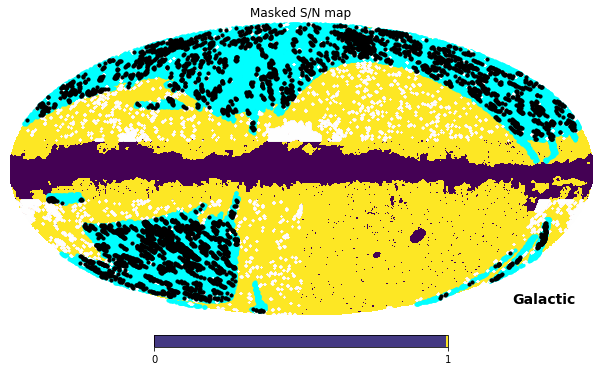

In [33]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='cyan',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)
hp.visufunc.projscatter(unionLons, unionLats,c='k',lonlat=True,s=10)

In [34]:
len(unionLons)

5480

---

In [62]:
amfFull = pd.read_csv('data/amfFull.tsv',sep='|')

c = SkyCoord(amfFull['RAJ2000'],amfFull['DEJ2000'],frame='icrs',unit='deg')

amfFull['GLAT'] = c.galactic.b.degree
amfFull['GLON'] = c.galactic.l.degree

amfFull['GLAT'] = np.around(amfFull['GLAT'].values,1)
amfFull['GLON'] = np.around(amfFull['GLON'].values,1)

In [63]:
for i in range(len(unionLons)):
    print(i)
    amfFull.reset_index()
    amfFull.drop(amfFull[(amfFull['GLAT']==unionLats[i]) & (amfFull['GLON']==unionLons[i])].index,inplace=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358


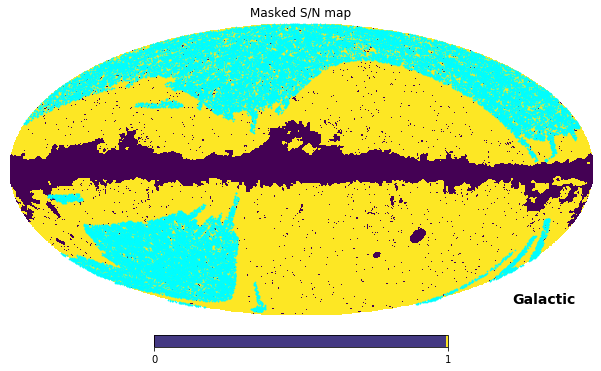

In [64]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='cyan',lonlat=True,s=0.5)

In [65]:
amfFull[(amfFull['GLAT']==unionLats[0]) & (amfFull['GLON']==unionLons[0])]

Empty DataFrame
Columns: [ID, AMF9, RAJ2000, DEJ2000, z, Lk, Lambda200, r200, rc, c, str-rh, GLAT, GLON]
Index: []

In [66]:
amfFull.sort_values(by=['Lambda200'], ascending=False)

ID              AMF9   RAJ2000  DEJ2000       z        Lk  \
0          4  J013539.1+204447   23.9128  20.7465  0.0601  176.9125   
1          5  J172231.8+320823  260.6324  32.1398  0.2252  222.1219   
2          6  J131131.1-012008  197.8796  -1.3356  0.2042  171.6872   
6         10  J133245.0+503205  203.1873  50.5346  0.3110  164.8704   
8         12  J232058.4+291210  350.2432  29.2029  0.5231  165.0015   
...      ...               ...       ...      ...     ...       ...   
46473  54272  J221090.0+164819  332.5373  16.8053  0.2720   19.0528   
46474  54273  J212414.7-053519  321.0614  -5.5885  0.4036    7.3319   
46475  54274  J104720.5-025526  161.7603  -2.9238  0.2064   11.9584   
46477  54276  J085114.6+015313  132.8109   1.8870  0.2697   12.2539   
46478  54277  J132144.5+565017  200.4356  56.8381  0.1359   16.1046   

       Lambda200   r200     rc       c   str-rh  GLAT   GLON  
0       219.3663  1.946  0.925   2.104  73.0001 -40.9  136.7  
1       200.7117  1.784  0.625   2.856  35.0001  31.8   55.6  
2       192.0829  1.773  0.227   7.792   9.0001  61.1  313.4  
6       179.1883  1.663  0.422   3.939  31.0001  65.3  107.1  
8       174.7108  1.518  0.390   3.892  69.0001 -29.6  100.2  
...          ...    ...    ...     ...      ...   ...    ...  
46473    20.0008  0.774  0.059  13.136  73.0856 -31.2   76.5  
46474    20.0008  0.734  0.260   2.823  85.1216 -36.3   46.9  
46475    20.0006  0.790  0.090   8.781   9.1111  47.5  253.1  
46477    20.0002  0.772  0.260   2.971  12.1012  27.3  225.8  
46478    20.0000  0.810  0.210   3.855  33.1023  59.8  114.7  

[40999 rows x 13 columns]

In [69]:
# Read in ymaps, stddevs (in Galactic coordinates)
nilc_ymap = hp.read_map('fitsData/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
nilc_stddevmap = hp.read_map('fitsData/COM_CompMap_Compton-SZMap-nilc-stddev_2048_R2.00.fits')

# Smooth noise map by 1 degree
# The essential difference between Burenin and this, is that he uses
# a 1 degree radius median filter for smoothing (not available on healpy)
stddev_smoothed = hp.smoothing(nilc_stddevmap,fwhm=np.radians(1.))

# Calculate signal over noise (smoothed)
sn_smoothed_n = nilc_ymap/stddev_smoothed

# Smooth the sn_smoothed_n map by 1 degree
sn_smoothed_n_smoothed = hp.smoothing(sn_smoothed_n,fwhm=np.radians(1.))

# Subtract the smoothed signal to noise map from the signal to noise map
sn_result = sn_smoothed_n - sn_smoothed_n_smoothed

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [75]:
# Convert to map
sn_masked = hp.ma(sn_result,badval=+1.6375e+30)
sn_masked.mask = np.logical_not(mask)

In [80]:
amfFull['sn'] = sn_masked[hp.ang2pix(2048,amfFull['GLON'],amfFull['GLAT'],lonlat=True)]

amfFull2 = amfFull
amfFull2['sn'] = ((amfFull['sn']+1.15)/1.65)

In [81]:
amfFull2.sort_values(by=['sn'], ascending=False)

ID              AMF9   RAJ2000  DEJ2000       z        Lk  \
5229    5960  J125915.1+275755  194.8130  27.9654  0.1583   27.0638   
506      587  J171225.4+640307  258.1058  64.0520  0.0827   90.8623   
2          6  J131131.1-012008  197.8796  -1.3356  0.2042  171.6872   
340      401  J084258.1+362127  130.7422  36.3575  0.2999   68.9492   
17        22  J215338.4+174147  328.4102  17.6964  0.2733  130.3337   
...      ...               ...       ...      ...     ...       ...   
25702  29434  J031257.9+411957   48.2413  41.3325  0.1790   10.5484   
42577  49444  J225430.6+244749  343.6277  24.7969  0.4107    6.0589   
25717  29451  J165919.6+263101  254.8316  26.5170  0.3742   28.4251   
39719  46016  J135843.5+554342  209.6811  55.7283  0.2299   10.3848   
22046  25156  J224158.1+095608  340.4921   9.9356  0.3428   11.7508   

       Lambda200   r200     rc      c   str-rh  GLAT   GLON         sn  
5229     41.7228  1.056  0.170  6.211  21.0111  88.1   59.2  34.026888  
506      78.3255  1.349  0.203  6.658  42.0001  35.0   93.9  29.367697  
2       192.0829  1.773  0.227  7.792   9.0001  61.1  313.4  19.530613  
340      85.9212  1.295  0.190  6.815  32.0005  37.3  186.4  19.278693  
17      159.5833  1.621  0.230  7.046  72.0002 -27.8   74.0  17.819830  
...          ...    ...    ...    ...      ...   ...    ...        ...  
25702    24.9689  0.868  0.270  3.214  61.0164 -14.1  149.6  -4.239254  
42577    20.7231  0.742  0.350  2.120  70.0954 -30.9   91.8  -4.270838  
25717    24.9645  0.808  0.280  2.885  30.0585  35.3   47.5  -4.481518  
39719    21.2682  0.802  0.230  3.487  33.0876  58.9  104.5  -4.531201  
22046    26.3475  0.834  0.280  2.979  77.0536 -41.4   78.2  -4.548337  

[40999 rows x 14 columns]

(4.5, 35)

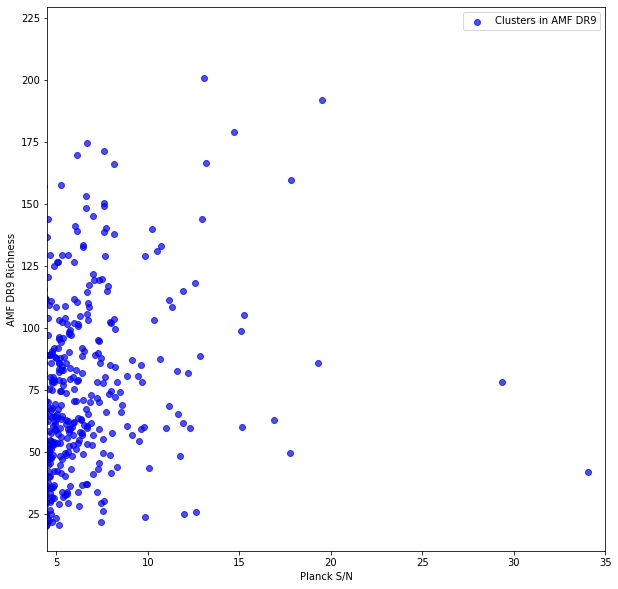

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(amfFull2['sn'],amfFull2['Lambda200'],c='blue',alpha=.7,label="Clusters in AMF DR9");
plt.legend()
plt.xlabel("Planck S/N")
plt.ylabel("AMF DR9 Richness")
plt.xlim(4.5,35)

In [2]:
# Read in Planck catalog
plsz2 = pd.read_csv('data/planck_sz2.csv',header=1)
plsz2.columns = ['pl_no','pl_name','pl_glon','pl_glat','pl_ra','pl_dec','pl_poserr','pl_sn',\
                   'pl_pipe','pl_pipedet','pl_pccs2','pl_psz','pl_irflag','pl_qneural','pl_y5r500',\
                   'pl_y5r500err','pl_valid','pl_zid','pl_z','pl_msz','pl_mszerrup','pl_mszerrlow',\
                   'pl_mcxc','pl_red','pl_act','pl_spt','pl_wise','pl_ami','pl_cosmo','pl_comment']

In [3]:
plsz2

pl_no             pl_name     pl_glon    pl_glat       pl_ra     pl_dec  \
0         3  PSZ2 G000.40-41.86    0.402995 -41.860793  316.084485 -41.354169   
1         4  PSZ2 G000.77-35.69    0.775050 -35.699386  307.972844 -40.598725   
2         5  PSZ2 G002.04-22.15    2.045799 -22.152166  291.359610 -36.517944   
3         6  PSZ2 G002.08-68.28    2.087016 -68.281561  349.632431 -36.332559   
4         7  PSZ2 G002.42+69.64    2.427468  69.648458  210.993317  15.688427   
...     ...                 ...         ...        ...         ...        ...   
1646   1649  PSZ2 G358.94-70.57  358.941697 -70.571028  352.780306 -36.549807   
1647   1650  PSZ2 G358.98-67.26  358.988135 -67.263448  348.926557 -37.779104   
1648   1651  PSZ2 G359.07-32.12  359.070655 -32.129302  303.018900 -41.486882   
1649   1652  PSZ2 G359.60-08.72  359.609382  -8.720568  275.091836 -33.531717   
1650   1653  PSZ2 G359.67-07.23  359.676522  -7.233634  273.549629 -32.790966   

      pl_poserr     pl_sn  pl_pipe  pl_pipedet  ...  pl_mszerrup  \
0      2.427383  9.704281        1         111  ...     0.320350   
1      2.343365  6.581792        2         111  ...     0.589880   
2      5.020757  5.125627        3           1  ...     0.000000   
3      5.427270  4.750398        2          10  ...     0.370542   
4      2.428572  4.621690        1         100  ...     0.465839   
...         ...       ...      ...         ...  ...          ...   
1646   3.157562  6.053402        3         111  ...     0.246912   
1647   1.724289  9.884269        3         111  ...     0.317408   
1648   2.428800  7.642749        1         111  ...     0.392048   
1649   2.428045  4.740269        1         110  ...     0.000000   
1650   1.255136  6.710938        3          11  ...     0.000000   

      pl_mszerrlow       pl_mcxc                pl_red  pl_act  \
0         0.344108  J2104.3-4120                   NaN     NaN   
1         0.611330  J2031.8-4037                   NaN     NaN   
2         0.000000           NaN                   NaN     NaN   
3         0.463434           NaN                   NaN     NaN   
4         0.484462           NaN  RMJ140358.9+154409.6     NaN   
...            ...           ...                   ...     ...   
1646      0.250808  J2331.2-3630                   NaN     NaN   
1647      0.302077  J2315.7-3746                   NaN     NaN   
1648      0.389491  J2012.0-4129                   NaN     NaN   
1649      0.000000           NaN                   NaN     NaN   
1650      0.000000           NaN                   NaN     NaN   

                pl_spt  pl_wise  pl_ami  pl_cosmo  \
0                  NaN      -10 -1000.0      True   
1     SPT-CLJ2031-4037        2 -1000.0      True   
2                  NaN       -3 -1000.0     False   
3                  NaN      -10 -1000.0     False   
4                  NaN      -10 -1000.0     False   
...                ...      ...     ...       ...   
1646               NaN      -10 -1000.0      True   
1647               NaN      -10 -1000.0      True   
1648  SPT-CLJ2012-4130      -10 -1000.0      True   
1649               NaN        0 -1000.0     False   
1650               NaN        0 -1000.0     False   

                                             pl_comment  
0                                                   NaN  
1                                                   NaN  
2                                                   NaN  
3                                 X-ray under-luminous,  
4                                 X-ray under-luminous,  
...                                                 ...  
1646                                                NaN  
1647                          Point sources at: 353GHz,  
1648                                                NaN  
1649                                                NaN  
1650  Point sources at: 217GHz, 353GHz, 545GHz, 857GHz,  

[1651 rows x 30 columns]

In [4]:
plsz2['pl_glat'] = np.around(plsz2['pl_glat'].values,1)
plsz2['pl_glon'] = np.around(plsz2['pl_glon'].values,1)

In [5]:
plsz2

pl_no             pl_name  pl_glon  pl_glat       pl_ra     pl_dec  \
0         3  PSZ2 G000.40-41.86      0.4    -41.9  316.084485 -41.354169   
1         4  PSZ2 G000.77-35.69      0.8    -35.7  307.972844 -40.598725   
2         5  PSZ2 G002.04-22.15      2.0    -22.2  291.359610 -36.517944   
3         6  PSZ2 G002.08-68.28      2.1    -68.3  349.632431 -36.332559   
4         7  PSZ2 G002.42+69.64      2.4     69.6  210.993317  15.688427   
...     ...                 ...      ...      ...         ...        ...   
1646   1649  PSZ2 G358.94-70.57    358.9    -70.6  352.780306 -36.549807   
1647   1650  PSZ2 G358.98-67.26    359.0    -67.3  348.926557 -37.779104   
1648   1651  PSZ2 G359.07-32.12    359.1    -32.1  303.018900 -41.486882   
1649   1652  PSZ2 G359.60-08.72    359.6     -8.7  275.091836 -33.531717   
1650   1653  PSZ2 G359.67-07.23    359.7     -7.2  273.549629 -32.790966   

      pl_poserr     pl_sn  pl_pipe  pl_pipedet  ...  pl_mszerrup  \
0      2.427383  9.704281        1         111  ...     0.320350   
1      2.343365  6.581792        2         111  ...     0.589880   
2      5.020757  5.125627        3           1  ...     0.000000   
3      5.427270  4.750398        2          10  ...     0.370542   
4      2.428572  4.621690        1         100  ...     0.465839   
...         ...       ...      ...         ...  ...          ...   
1646   3.157562  6.053402        3         111  ...     0.246912   
1647   1.724289  9.884269        3         111  ...     0.317408   
1648   2.428800  7.642749        1         111  ...     0.392048   
1649   2.428045  4.740269        1         110  ...     0.000000   
1650   1.255136  6.710938        3          11  ...     0.000000   

      pl_mszerrlow       pl_mcxc                pl_red  pl_act  \
0         0.344108  J2104.3-4120                   NaN     NaN   
1         0.611330  J2031.8-4037                   NaN     NaN   
2         0.000000           NaN                   NaN     NaN   
3         0.463434           NaN                   NaN     NaN   
4         0.484462           NaN  RMJ140358.9+154409.6     NaN   
...            ...           ...                   ...     ...   
1646      0.250808  J2331.2-3630                   NaN     NaN   
1647      0.302077  J2315.7-3746                   NaN     NaN   
1648      0.389491  J2012.0-4129                   NaN     NaN   
1649      0.000000           NaN                   NaN     NaN   
1650      0.000000           NaN                   NaN     NaN   

                pl_spt  pl_wise  pl_ami  pl_cosmo  \
0                  NaN      -10 -1000.0      True   
1     SPT-CLJ2031-4037        2 -1000.0      True   
2                  NaN       -3 -1000.0     False   
3                  NaN      -10 -1000.0     False   
4                  NaN      -10 -1000.0     False   
...                ...      ...     ...       ...   
1646               NaN      -10 -1000.0      True   
1647               NaN      -10 -1000.0      True   
1648  SPT-CLJ2012-4130      -10 -1000.0      True   
1649               NaN        0 -1000.0     False   
1650               NaN        0 -1000.0     False   

                                             pl_comment  
0                                                   NaN  
1                                                   NaN  
2                                                   NaN  
3                                 X-ray under-luminous,  
4                                 X-ray under-luminous,  
...                                                 ...  
1646                                                NaN  
1647                          Point sources at: 353GHz,  
1648                                                NaN  
1649                                                NaN  
1650  Point sources at: 217GHz, 353GHz, 545GHz, 857GHz,  

[1651 rows x 30 columns]